# Optuna Tuning | Neural Network
**Neural Network** hyper-parameter tuning for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

> **[CAUTION]** Do <u>NOT</u> execute "Run All", that will tell Optuna to run hyper-parameter tuning, regardless of whether you have already done it or not. Avoid running the _"Hyper-parameter tuning"_ subsections if you don't have to.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [1]:
# Data Analysis
import numpy as np
import pandas as pd

# Hyperparameter optimization
import optuna

# Machine learning
import os
import torch
import torch.nn as nn
import torch.optim as optim

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from collections import Counter

from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, fbeta_score, make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset

### 0.2 Constants

In [3]:
DATA_PATH = '../data/original/'
DATA_PATH_PROCESSED = '../data/processed/'

MODEL_NAME = 'nn' # Modify this to the model you are using

OPTUNA_PATH = '../optuna/'
OPTUNA_DIR = OPTUNA_PATH + MODEL_NAME + '/'

STUDY_NAME = "Diabetes_130-US"
STUDY_PATH_NONE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_none.log"
STUDY_PATH_RUS = OPTUNA_DIR + f"optuna_{MODEL_NAME}_rus.log"
STUDY_PATH_SMOTE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote.log"
STUDY_PATH_SMOTE_TOMEK = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote-tomek.log"

# Ensure the directories exist
os.makedirs(OPTUNA_DIR, exist_ok=True)
os.makedirs(os.path.dirname(STUDY_PATH_NONE), exist_ok=True)

N_TRIALS = 100
RANDOM_STATE = 38

# Torch configurations
torch.manual_seed(RANDOM_STATE)
EPOCHS = 200
PATIENCE = 15
NUM_CLASSES = 2
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {DEVICE}")

SCORE_NAME = 'F1-Score'
SCORING = make_scorer(fbeta_score, beta=1, average='macro')

Using device: cuda


### 0.3 Loading datasets

In [4]:
train_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'train.csv',
    na_values='?',
    keep_default_na=False
)

test_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'test.csv',
    na_values='?',
    keep_default_na=False
)

## **1. Feature Scaling & NN structure**
Applying scaling to numerical features.

In [5]:
target = 'readmitted'

X_train = train_set.drop(target, axis=1)
y_train = train_set[target]

X_test = test_set.drop(target, axis=1)
y_test = test_set[target]

### 1.1 Scaling
Applying scaling to numerical features, while leaving boolean features untouched.

In [6]:
NUMERICAL_COLUMNS = [
    'age', 'time_in_hospital', 'num_medications',
    'num_emergency', 'num_inpatient', 'num_diagnoses'
]

In [7]:
scaler = MinMaxScaler()

X_train[NUMERICAL_COLUMNS] = scaler.fit_transform(X_train[NUMERICAL_COLUMNS])
X_test[NUMERICAL_COLUMNS] = scaler.transform(X_test[NUMERICAL_COLUMNS])

In [8]:
print('Train set:', Counter(y_train))
print('Test set:', Counter(y_test))

Train set: Counter({0: 45522, 1: 4523})
Test set: Counter({0: 19510, 1: 1938})


### 1.2 NN structure

In [9]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn, dropouts, output_size):
        super(NN, self).__init__()
        
        layers = []
        for i in range(len(hidden_layers)):
            layers.append(nn.Linear(input_size if i == 0 else hidden_layers[i - 1], hidden_layers[i]))
            layers.append(activation_fn)
            layers.append(nn.Dropout(dropouts[i]))
        layers.append(nn.Linear(hidden_layers[-1], output_size))
        
        self.network = nn.Sequential(*layers)


    def forward(self, x):
        return self.network(x)


    def compile(self, optimizer, criterion):
        self.optimizer = optimizer
        self.criterion = criterion


    def fit(self, train_loader, val_loader, device, patience=5, max_epochs=100):
        best_f1 = 0
        epochs_no_improve = 0
        early_stop = False

        for epoch in tqdm(range(max_epochs)):
            # Training phase
            self.train()
            
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                self.optimizer.zero_grad()
                
                outputs = self(X_batch)
                
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                
                self.optimizer.step()

            # Validation phase
            val_f1 = self.validate(val_loader, device)

            # Early stopping logic
            if val_f1 > best_f1:
                best_f1 = val_f1
                epochs_no_improve = 0
                best_model_weights = self.state_dict()
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    early_stop = True
                    break
        
        # Load the best weights
        if best_model_weights is not None:
            self.load_state_dict(best_model_weights)
        
        return best_f1, early_stop

    def validate(self, dataloader, device):
        self.eval()
        
        all_preds, all_labels = [], []
        with torch.no_grad():
            for X_batch, y_batch in dataloader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = self(X_batch)
                
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())
        
        return f1_score(all_labels, all_preds, average='macro')
    
    
    def predict(self, X, device="cpu"):
        """
        Generate predictions for the input data.

        Parameters:
        - X (array-like or tensor): Input data. Can be a NumPy array, Pandas DataFrame, or PyTorch tensor.
        - device (str): The device to use for computation ("cpu" or "cuda").

        Returns:
        - predictions (numpy.ndarray): Predicted class labels.
        """
        self.eval()  # Set the model to evaluation mode

        # Convert input data to a PyTorch tensor if needed
        if isinstance(X, np.ndarray):
            X = torch.tensor(X, dtype=torch.float32)
        elif isinstance(X, pd.DataFrame):
            X = torch.tensor(X.values, dtype=torch.float32)

        # Move data to the appropriate device
        X = X.to(device)

        with torch.no_grad():
            outputs = self(X)
            predictions = torch.argmax(outputs, dim=1)  # Get the index of the highest logit

        return predictions.cpu().numpy()  # Convert predictions to a NumPy array

In [10]:
class DiabeticDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

## **2. Optuna Hyper-parameter Tuning | No under/oversampling**
Hyper-parameter tuning of the model using Optuna, with no undersampling/oversampling.

### 2.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [11]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter suggestions
    hidden_layers = [trial.suggest_int(f"n_units_l{i}", 16, 128, step=8) for i in range(trial.suggest_int("n_layers", 1, 3))]
    dropouts = [trial.suggest_float(f"dropout_l{i}", 0.0, 0.5, step=0.05) for i in range(len(hidden_layers))]
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    optimizer_name = trial.suggest_categorical("optimizer", ['adam', 'sgd', 'rmsprop'])
    
    # Creating the activation function
    activation_name = trial.suggest_categorical("activation", ['relu', 'selu', 'tanh', 'sigmoid'])
    activation_dict = {
        'relu': nn.ReLU,
        'selu': nn.SELU,
        'tanh': nn.Tanh,
        'sigmoid': nn.Sigmoid
    }
    activation_fn = activation_dict[activation_name]()
    
    # Loading the optimizer
    optimizer_dict = {
        'adam': torch.optim.Adam,
        'sgd': torch.optim.SGD,
        'rmsprop': torch.optim.RMSprop
    }
    optimizer_fn = optimizer_dict[optimizer_name]
    
    # Stratified K-Fold setup
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        # Get the current fold
        X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        # Convert dataset to tensors
        X_train_tensor = torch.tensor(X_train_fold.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_fold.values, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val_fold.values, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val_fold.values, dtype=torch.long)
        
        # Create dataloaders for the current fold
        train_loader = DataLoader(DiabeticDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(DiabeticDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
        
        # Create a new model instance for each fold
        model = NN(
            input_size=X_train.shape[1],
            hidden_layers=hidden_layers,
            activation_fn=activation_fn,
            dropouts=dropouts,
            output_size=NUM_CLASSES
        ).to(DEVICE)
        
        # Compile the model
        optimizer = optimizer_fn(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
        model.compile(optimizer, criterion)

        # Train and validate the model
        f1, _ = model.fit(
            train_loader,
            val_loader,
            DEVICE,
            patience=PATIENCE,
            max_epochs=EPOCHS
        )
        scores.append(f1)

    # Return the average F1-Macro score across all folds
    f1_mean = sum(scores) / len(scores)
    print("Cross validation scores: {}".format(list(map(lambda x: round(float(x), 6), scores))))
    print("Average score: {}".format(f1_mean))
    
    return f1_mean

In [12]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_NONE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-01-23 07:47:56,744] Using an existing study with name 'Diabetes_130-US' instead of creating a new one.


### 2.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [ ]:
study.optimize(
    objective,
    n_trials=N_TRIALS // 5,
    n_jobs=1 # GPU can only support one job per time
)

  8%|▊         | 15/200 [00:14<02:57,  1.04it/s]
[I 2025-01-22 15:29:01,813] Trial 0 finished with value: 0.47633597337075617 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 128, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.30000000000000004, 'lr': 0.0026536590823549467, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


  8%|▊         | 15/200 [00:16<03:28,  1.13s/it]
[I 2025-01-22 15:30:25,988] Trial 1 finished with value: 0.47633597337075617 and parameters: {'n_layers': 3, 'n_units_l0': 72, 'n_units_l1': 112, 'n_units_l2': 128, 'dropout_l0': 0.45, 'dropout_l1': 0.15000000000000002, 'dropout_l2': 0.30000000000000004, 'lr': 0.004156363540430432, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


  8%|▊         | 15/200 [00:12<02:39,  1.16it/s]
[I 2025-01-22 15:31:30,465] Trial 2 finished with value: 0.47633597337075617 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 16, 'dropout_l0': 0.1, 'dropout_l1': 0.2, 'lr': 0.0024751269602064094, 'batch_size': 32, 'optimizer': 'sgd', 'activation': 'selu'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


  8%|▊         | 15/200 [00:05<01:09,  2.68it/s]
[I 2025-01-22 15:31:58,511] Trial 3 finished with value: 0.47633597337075617 and parameters: {'n_layers': 2, 'n_units_l0': 56, 'n_units_l1': 40, 'dropout_l0': 0.2, 'dropout_l1': 0.30000000000000004, 'lr': 0.0002078883867918235, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


  8%|▊         | 15/200 [00:13<02:41,  1.14it/s]
[I 2025-01-22 15:33:03,043] Trial 4 finished with value: 0.47633597337075617 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 16, 'dropout_l0': 0.25, 'dropout_l1': 0.25, 'lr': 0.0036906476729552783, 'batch_size': 32, 'optimizer': 'sgd', 'activation': 'selu'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


  8%|▊         | 15/200 [00:14<03:03,  1.01it/s]
[I 2025-01-22 15:34:17,321] Trial 5 finished with value: 0.47633597337075617 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 56, 'dropout_l0': 0.45, 'dropout_l1': 0.45, 'lr': 7.750283070716948e-05, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


  8%|▊         | 15/200 [00:05<01:02,  2.95it/s]
[I 2025-01-22 15:34:42,722] Trial 6 finished with value: 0.47633597337075617 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 88, 'dropout_l0': 0.15000000000000002, 'dropout_l1': 0.05, 'lr': 0.09905695041134392, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


  8%|▊         | 15/200 [00:08<01:48,  1.70it/s]
[I 2025-01-22 15:35:27,638] Trial 7 finished with value: 0.47633597337075617 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 104, 'dropout_l0': 0.4, 'dropout_l1': 0.45, 'lr': 0.012590518424726376, 'batch_size': 64, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


  8%|▊         | 15/200 [00:29<06:04,  1.97s/it]
[I 2025-01-22 15:37:55,245] Trial 8 finished with value: 0.47633597337075617 and parameters: {'n_layers': 3, 'n_units_l0': 96, 'n_units_l1': 96, 'n_units_l2': 72, 'dropout_l0': 0.2, 'dropout_l1': 0.5, 'dropout_l2': 0.30000000000000004, 'lr': 0.001375981904050833, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


  8%|▊         | 15/200 [00:05<01:12,  2.54it/s]
[I 2025-01-22 15:38:24,696] Trial 9 finished with value: 0.47633597337075617 and parameters: {'n_layers': 3, 'n_units_l0': 48, 'n_units_l1': 120, 'n_units_l2': 96, 'dropout_l0': 0.1, 'dropout_l1': 0.4, 'dropout_l2': 0.1, 'lr': 0.028222548122153395, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


  8%|▊         | 15/200 [00:07<01:30,  2.04it/s]
[I 2025-01-22 15:39:02,158] Trial 10 finished with value: 0.48849118131497854 and parameters: {'n_layers': 1, 'n_units_l0': 16, 'dropout_l0': 0.35000000000000003, 'lr': 1.0655954353055574e-05, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 10 with value: 0.48849118131497854.


Cross validation scores: [0.481145, 0.487989, 0.47943, 0.517355, 0.476538]
Average score: 0.48849118131497854


  8%|▊         | 17/200 [00:08<01:29,  2.04it/s]
[I 2025-01-22 15:39:40,504] Trial 11 finished with value: 0.4857409965978835 and parameters: {'n_layers': 1, 'n_units_l0': 16, 'dropout_l0': 0.35000000000000003, 'lr': 1.1427180396551256e-05, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 10 with value: 0.48849118131497854.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.511146, 0.48853]
Average score: 0.4857409965978835


  8%|▊         | 15/200 [00:07<01:30,  2.05it/s]
[I 2025-01-22 15:40:18,846] Trial 12 finished with value: 0.49071376968418773 and parameters: {'n_layers': 1, 'n_units_l0': 16, 'dropout_l0': 0.30000000000000004, 'lr': 1.0662250774067458e-05, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 12 with value: 0.49071376968418773.


Cross validation scores: [0.480271, 0.488453, 0.477396, 0.52335, 0.484098]
Average score: 0.49071376968418773


  8%|▊         | 15/200 [00:07<01:28,  2.09it/s]
[I 2025-01-22 15:40:55,416] Trial 13 finished with value: 0.47779193206708825 and parameters: {'n_layers': 1, 'n_units_l0': 24, 'dropout_l0': 0.0, 'lr': 1.0009012235382151e-05, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 12 with value: 0.49071376968418773.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.483605, 0.476325]
Average score: 0.47779193206708825


  8%|▊         | 15/200 [00:07<01:30,  2.04it/s]
[I 2025-01-22 15:41:32,428] Trial 14 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'n_units_l0': 32, 'dropout_l0': 0.30000000000000004, 'lr': 5.8936368371030734e-05, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 12 with value: 0.49071376968418773.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


  8%|▊         | 15/200 [00:07<01:34,  1.96it/s]
[I 2025-01-22 15:42:10,729] Trial 15 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'n_units_l0': 40, 'dropout_l0': 0.5, 'lr': 0.00020302837901969978, 'batch_size': 64, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 12 with value: 0.49071376968418773.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


  8%|▊         | 15/200 [00:21<04:31,  1.47s/it]
[I 2025-01-22 15:44:00,193] Trial 16 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'n_units_l0': 16, 'dropout_l0': 0.30000000000000004, 'lr': 3.458897432015984e-05, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 12 with value: 0.49071376968418773.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


  8%|▊         | 15/200 [00:07<01:30,  2.05it/s]
[I 2025-01-22 15:44:36,593] Trial 17 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'n_units_l0': 32, 'dropout_l0': 0.35000000000000003, 'lr': 0.00026773060924012226, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 12 with value: 0.49071376968418773.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


  8%|▊         | 16/200 [00:06<01:18,  2.34it/s]
[I 2025-01-22 15:45:11,458] Trial 18 finished with value: 0.5121875576273789 and parameters: {'n_layers': 1, 'n_units_l0': 40, 'dropout_l0': 0.25, 'lr': 2.6285824031368948e-05, 'batch_size': 64, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 18 with value: 0.5121875576273789.


Cross validation scores: [0.529168, 0.521557, 0.48325, 0.511256, 0.515707]
Average score: 0.5121875576273789


  8%|▊         | 15/200 [00:06<01:21,  2.26it/s]
[I 2025-01-22 15:45:46,772] Trial 19 finished with value: 0.49054974928421535 and parameters: {'n_layers': 1, 'n_units_l0': 40, 'dropout_l0': 0.25, 'lr': 3.0890756510965624e-05, 'batch_size': 64, 'optimizer': 'sgd', 'activation': 'selu'}. Best is trial 18 with value: 0.5121875576273789.


Cross validation scores: [0.491334, 0.47858, 0.501976, 0.498626, 0.482233]
Average score: 0.49054974928421535


In [71]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 18
Best Parameters: {'n_layers': 1, 'n_units_l0': 40, 'dropout_l0': 0.25, 'lr': 2.6285824031368948e-05, 'batch_size': 64, 'optimizer': 'sgd', 'activation': 'tanh'}
Best Value: 0.5121875576273789


### 2.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [13]:
optuna.visualization.plot_optimization_history(study)

In [14]:
optuna.visualization.plot_slice(study)

In [15]:
optuna.visualization.plot_param_importances(study)

In [16]:
optuna.visualization.plot_parallel_coordinate(study)

In [17]:
optuna.visualization.plot_contour(study)

In [18]:
optuna.visualization.plot_timeline(study)

### 2.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [19]:
# Extract hyperparameters
best_params = study.best_params

hidden_layers = [best_params[f"n_units_l{i}"] for i in range(best_params["n_layers"])]
dropouts = [best_params[f"dropout_l{i}"] for i in range(len(hidden_layers))]
learning_rate = best_params["lr"]
batch_size = best_params["batch_size"]

# Creating the activation function
activation_name = best_params["activation"]
activation_dict = {
    'relu': nn.ReLU,
    'selu': nn.SELU,
    'tanh': nn.Tanh,
    'sigmoid': nn.Sigmoid
}
activation_fn = activation_dict[activation_name]()

# Loading the optimizer
optimizer_name = best_params["optimizer"]
optimizer_dict = {
    'adam': torch.optim.Adam,
    'sgd': torch.optim.SGD,
    'rmsprop': torch.optim.RMSprop
}
optimizer_fn = optimizer_dict[optimizer_name]

# Split the original training set into training and validation sets
X_train_tmp, X_val, y_train_tmp, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

# Convert dataset to tensors
X_train_tensor = torch.tensor(X_train_tmp.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_tmp.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Create dataloaders for the entire dataset
train_loader = DataLoader(DiabeticDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(DiabeticDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)

# Create a new model instance
model = NN(
    input_size=X_train.shape[1],
    hidden_layers=hidden_layers,
    activation_fn=activation_fn,
    dropouts=dropouts,
    output_size=NUM_CLASSES
).to(DEVICE)

# Compile the model
optimizer = optimizer_fn(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
model.compile(optimizer, criterion)

# Train and validate the model
model.fit(
    train_loader,
    val_loader,
    DEVICE,
    patience=PATIENCE * 2,
    max_epochs=EPOCHS
)

 21%|██        | 42/200 [00:18<01:08,  2.32it/s]


(np.float64(0.5010263542934792), True)

In [20]:
# Predictions
y_train_pred_none = model.predict(X_train, device=DEVICE)
y_test_pred_none = model.predict(X_test, device=DEVICE)

In [21]:
ac_train_none = accuracy_score(y_train, y_train_pred_none)
ac_test_none = accuracy_score(y_test, y_test_pred_none)

print('Train accuracy: ', ac_train_none)
print('Test accuracy: ', ac_test_none)

Train accuracy:  0.909621340793286
Test accuracy:  0.9096419246549795


In [22]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_none,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.91      1.00      0.95     19510
      Early-readmission       0.00      0.00      0.00      1938

               accuracy                           0.91     21448
              macro avg       0.45      0.50      0.48     21448
           weighted avg       0.83      0.91      0.87     21448



/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [23]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_none = recall_score(y_test, y_test_pred_none, average='macro')
precision_none = precision_score(y_test, y_test_pred_none, average='macro')
f1_none = f1_score(y_test, y_test_pred_none, average='macro')
roc_auc_none = roc_auc_score(y_test, y_test_pred_none, average='macro')
accuracy_none = accuracy_score(y_test, y_test_pred_none)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<Axes: >

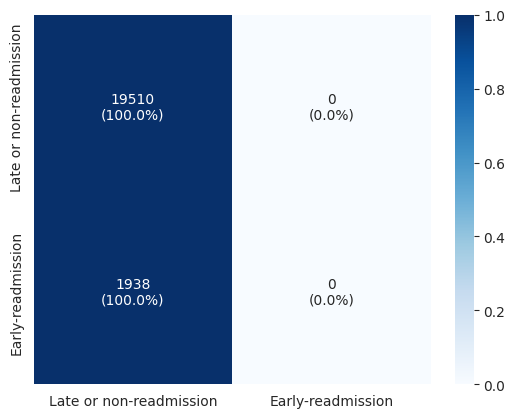

In [24]:
# Visualize confusion matrix with both absolute and percentage values
cm_none = confusion_matrix(y_test, y_test_pred_none)
cm_none_norm = confusion_matrix(y_test, y_test_pred_none, normalize='true')

annotations_none = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_none, cm_none_norm)
])

sns.heatmap(
    cm_none_norm,
    annot=annotations_none,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **3. Optuna Hyper-parameter Tuning | Undersampling**
Hyper-parameter tuning of the model using Optuna, and undersampling with RandomUnderSampler.

### 3.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [25]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter suggestions
    hidden_layers = [trial.suggest_int(f"n_units_l{i}", 16, 128, step=8) for i in range(trial.suggest_int("n_layers", 1, 3))]
    dropouts = [trial.suggest_float(f"dropout_l{i}", 0.0, 0.5, step=0.05) for i in range(len(hidden_layers))]
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    optimizer_name = trial.suggest_categorical("optimizer", ['adam', 'sgd', 'rmsprop'])
    
    # Creating the activation function
    activation_name = trial.suggest_categorical("activation", ['relu', 'selu', 'tanh', 'sigmoid'])
    activation_dict = {
        'relu': nn.ReLU,
        'selu': nn.SELU,
        'tanh': nn.Tanh,
        'sigmoid': nn.Sigmoid
    }
    activation_fn = activation_dict[activation_name]()
    
    # Loading the optimizer
    optimizer_dict = {
        'adam': torch.optim.Adam,
        'sgd': torch.optim.SGD,
        'rmsprop': torch.optim.RMSprop
    }
    optimizer_fn = optimizer_dict[optimizer_name]
    
    # Sampling strategy
    sampler = RandomUnderSampler(random_state=RANDOM_STATE)
    
    # Stratified K-Fold setup
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        # Get the current fold
        X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        # Apply Random Under-Sampling
        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_fold, y_train_fold)
        
        # Convert dataset to tensors
        X_train_tensor = torch.tensor(X_train_resampled.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val_fold.values, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val_fold.values, dtype=torch.long)
        
        # Create dataloaders for the current fold
        train_loader = DataLoader(DiabeticDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(DiabeticDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
        
        # Create a new model instance for each fold
        model = NN(
            input_size=X_train.shape[1],
            hidden_layers=hidden_layers,
            activation_fn=activation_fn,
            dropouts=dropouts,
            output_size=NUM_CLASSES
        ).to(DEVICE)
        
        # Compile the model
        optimizer = optimizer_fn(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
        model.compile(optimizer, criterion)

        # Train and validate the model
        f1, _ = model.fit(
            train_loader,
            val_loader,
            DEVICE,
            patience=PATIENCE,
            max_epochs=EPOCHS
        )
        scores.append(f1)

    # Return the average F1-Macro score across all folds
    f1_mean = sum(scores) / len(scores)
    print("Cross validation scores: {}".format(list(map(lambda x: round(float(x), 6), scores))))
    print("Average score: {}".format(f1_mean))
    
    return f1_mean

In [26]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_RUS))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-23 07:48:20,586] Using an existing study with name 'Diabetes_130-US' instead of creating a new one.


### 3.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [ ]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=1 # GPU can only support one job per time
)

 10%|█         | 21/200 [00:04<00:42,  4.21it/s]
[I 2025-01-22 15:46:25,559] Trial 0 finished with value: 0.5397469541886388 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 128, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.30000000000000004, 'lr': 0.0026536590823549467, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 0 with value: 0.5397469541886388.


Cross validation scores: [0.539766, 0.549708, 0.548114, 0.529038, 0.532108]
Average score: 0.5397469541886388


  8%|▊         | 16/200 [00:04<00:51,  3.58it/s]
[I 2025-01-22 15:46:54,790] Trial 1 finished with value: 0.542243076035867 and parameters: {'n_layers': 3, 'n_units_l0': 72, 'n_units_l1': 112, 'n_units_l2': 128, 'dropout_l0': 0.45, 'dropout_l1': 0.15000000000000002, 'dropout_l2': 0.30000000000000004, 'lr': 0.004156363540430432, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 1 with value: 0.542243076035867.


Cross validation scores: [0.537363, 0.550787, 0.557215, 0.534989, 0.530861]
Average score: 0.542243076035867


  9%|▉         | 18/200 [00:04<00:41,  4.43it/s]
[I 2025-01-22 15:47:22,072] Trial 2 finished with value: 0.5262881575016272 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 16, 'dropout_l0': 0.1, 'dropout_l1': 0.2, 'lr': 0.0024751269602064094, 'batch_size': 32, 'optimizer': 'sgd', 'activation': 'selu'}. Best is trial 1 with value: 0.542243076035867.


Cross validation scores: [0.519968, 0.524714, 0.531864, 0.529293, 0.525602]
Average score: 0.5262881575016272


 12%|█▏        | 23/200 [00:02<00:18,  9.70it/s]
[I 2025-01-22 15:47:34,628] Trial 3 finished with value: 0.5474682536976797 and parameters: {'n_layers': 2, 'n_units_l0': 56, 'n_units_l1': 40, 'dropout_l0': 0.2, 'dropout_l1': 0.30000000000000004, 'lr': 0.0002078883867918235, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 3 with value: 0.5474682536976797.


Cross validation scores: [0.54356, 0.549562, 0.553582, 0.546133, 0.544504]
Average score: 0.5474682536976797


 15%|█▌        | 30/200 [00:06<00:37,  4.53it/s]
[I 2025-01-22 15:48:02,314] Trial 4 finished with value: 0.5289781501514452 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 16, 'dropout_l0': 0.25, 'dropout_l1': 0.25, 'lr': 0.0036906476729552783, 'batch_size': 32, 'optimizer': 'sgd', 'activation': 'selu'}. Best is trial 3 with value: 0.5474682536976797.


Cross validation scores: [0.526751, 0.524553, 0.539062, 0.531919, 0.522605]
Average score: 0.5289781501514452


 12%|█▏        | 24/200 [00:06<00:44,  3.98it/s]
[I 2025-01-22 15:48:33,945] Trial 5 finished with value: 0.5240603615345591 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 56, 'dropout_l0': 0.45, 'dropout_l1': 0.45, 'lr': 7.750283070716948e-05, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 3 with value: 0.5474682536976797.


Cross validation scores: [0.51909, 0.532346, 0.516246, 0.53045, 0.522169]
Average score: 0.5240603615345591


 12%|█▎        | 25/200 [00:02<00:16, 10.48it/s]
[I 2025-01-22 15:48:43,848] Trial 6 finished with value: 0.5121946691035559 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 88, 'dropout_l0': 0.15000000000000002, 'dropout_l1': 0.05, 'lr': 0.09905695041134392, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 3 with value: 0.5474682536976797.


Cross validation scores: [0.544879, 0.476352, 0.476325, 0.528987, 0.534429]
Average score: 0.5121946691035559


 12%|█▏        | 23/200 [00:03<00:26,  6.58it/s]
[I 2025-01-22 15:49:03,712] Trial 7 finished with value: 0.5378870913627901 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 104, 'dropout_l0': 0.4, 'dropout_l1': 0.45, 'lr': 0.012590518424726376, 'batch_size': 64, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 3 with value: 0.5474682536976797.


Cross validation scores: [0.541594, 0.535719, 0.543902, 0.546794, 0.521425]
Average score: 0.5378870913627901


  8%|▊         | 16/200 [00:07<01:26,  2.14it/s]
[I 2025-01-22 15:50:23,642] Trial 8 finished with value: 0.5389065991926713 and parameters: {'n_layers': 3, 'n_units_l0': 96, 'n_units_l1': 96, 'n_units_l2': 72, 'dropout_l0': 0.2, 'dropout_l1': 0.5, 'dropout_l2': 0.30000000000000004, 'lr': 0.001375981904050833, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 3 with value: 0.5474682536976797.


Cross validation scores: [0.516926, 0.554735, 0.550631, 0.543169, 0.529072]
Average score: 0.5389065991926713


 11%|█         | 22/200 [00:02<00:19,  9.08it/s]
[I 2025-01-22 15:50:33,212] Trial 9 finished with value: 0.47633597337075617 and parameters: {'n_layers': 3, 'n_units_l0': 48, 'n_units_l1': 120, 'n_units_l2': 96, 'dropout_l0': 0.1, 'dropout_l1': 0.4, 'dropout_l2': 0.1, 'lr': 0.028222548122153395, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 3 with value: 0.5474682536976797.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


  8%|▊         | 17/200 [00:01<00:17, 10.44it/s]
[I 2025-01-22 15:51:07,931] Trial 10 finished with value: 0.496922019235131 and parameters: {'n_layers': 1, 'n_units_l0': 16, 'dropout_l0': 0.0, 'lr': 6.365353825677702e-05, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 3 with value: 0.5474682536976797.


Cross validation scores: [0.502726, 0.476352, 0.510912, 0.513757, 0.480862]
Average score: 0.496922019235131


  8%|▊         | 17/200 [00:02<00:30,  6.01it/s]
[I 2025-01-22 15:51:28,885] Trial 11 finished with value: 0.5247787956484999 and parameters: {'n_layers': 3, 'n_units_l0': 40, 'n_units_l1': 56, 'n_units_l2': 128, 'dropout_l0': 0.5, 'dropout_l1': 0.1, 'dropout_l2': 0.5, 'lr': 0.00023176141563770414, 'batch_size': 64, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 3 with value: 0.5474682536976797.


Cross validation scores: [0.514966, 0.521483, 0.540691, 0.523006, 0.523749]
Average score: 0.5247787956484999


 10%|▉         | 19/200 [00:06<01:06,  2.73it/s]
[I 2025-01-22 15:52:46,136] Trial 12 finished with value: 0.5046587684009505 and parameters: {'n_layers': 1, 'n_units_l0': 40, 'dropout_l0': 0.30000000000000004, 'lr': 1.0613565497819229e-05, 'batch_size': 16, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 3 with value: 0.5474682536976797.


Cross validation scores: [0.515668, 0.452227, 0.532881, 0.497777, 0.524741]
Average score: 0.5046587684009505


 20%|█▉        | 39/200 [00:04<00:17,  9.34it/s]
[I 2025-01-22 15:53:04,868] Trial 13 finished with value: 0.5468170996830718 and parameters: {'n_layers': 3, 'n_units_l0': 80, 'n_units_l1': 40, 'n_units_l2': 24, 'dropout_l0': 0.30000000000000004, 'dropout_l1': 0.15000000000000002, 'dropout_l2': 0.30000000000000004, 'lr': 0.0002475058998441034, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 3 with value: 0.5474682536976797.


Cross validation scores: [0.547562, 0.553104, 0.554472, 0.542563, 0.536385]
Average score: 0.5468170996830718


 10%|█         | 21/200 [00:01<00:16, 10.62it/s]
[I 2025-01-22 15:53:14,540] Trial 14 finished with value: 0.5396938314405622 and parameters: {'n_layers': 1, 'n_units_l0': 88, 'dropout_l0': 0.25, 'lr': 0.00031645213001527594, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 3 with value: 0.5474682536976797.


Cross validation scores: [0.542041, 0.548792, 0.548789, 0.531079, 0.527768]
Average score: 0.5396938314405622


 12%|█▏        | 24/200 [00:02<00:18,  9.39it/s]
[I 2025-01-22 15:53:28,971] Trial 15 finished with value: 0.5317402979605573 and parameters: {'n_layers': 3, 'n_units_l0': 24, 'n_units_l1': 40, 'n_units_l2': 16, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.0, 'dropout_l2': 0.5, 'lr': 0.00038460557297793473, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 3 with value: 0.5474682536976797.


Cross validation scores: [0.544541, 0.549055, 0.476325, 0.548028, 0.540752]
Average score: 0.5317402979605573


 20%|██        | 41/200 [00:04<00:16,  9.46it/s]
[I 2025-01-22 15:53:49,453] Trial 16 finished with value: 0.546000403192936 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 40, 'n_units_l2': 16, 'dropout_l0': 0.0, 'dropout_l1': 0.30000000000000004, 'dropout_l2': 0.0, 'lr': 3.782280350892808e-05, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 3 with value: 0.5474682536976797.


Cross validation scores: [0.545618, 0.547607, 0.552524, 0.547242, 0.537011]
Average score: 0.546000403192936


 10%|█         | 20/200 [00:01<00:17, 10.45it/s]
[I 2025-01-22 15:53:59,156] Trial 17 finished with value: 0.5389876014994982 and parameters: {'n_layers': 1, 'n_units_l0': 56, 'dropout_l0': 0.2, 'lr': 0.0006454474243252412, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 3 with value: 0.5474682536976797.


Cross validation scores: [0.544498, 0.5417, 0.543354, 0.537554, 0.527832]
Average score: 0.5389876014994982


 14%|█▍        | 28/200 [00:02<00:17,  9.99it/s]
[I 2025-01-22 15:54:14,526] Trial 18 finished with value: 0.5474178750189986 and parameters: {'n_layers': 2, 'n_units_l0': 32, 'n_units_l1': 72, 'dropout_l0': 0.30000000000000004, 'dropout_l1': 0.35000000000000003, 'lr': 0.00013509084258252524, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 3 with value: 0.5474682536976797.


Cross validation scores: [0.548255, 0.552828, 0.548326, 0.542617, 0.545063]
Average score: 0.5474178750189986


 22%|██▏       | 43/200 [00:05<00:21,  7.42it/s]
[I 2025-01-22 15:55:27,903] Trial 19 finished with value: 0.38568576691154355 and parameters: {'n_layers': 2, 'n_units_l0': 32, 'n_units_l1': 80, 'dropout_l0': 0.1, 'dropout_l1': 0.35000000000000003, 'lr': 1.2292932891010222e-05, 'batch_size': 64, 'optimizer': 'sgd', 'activation': 'selu'}. Best is trial 3 with value: 0.5474682536976797.


Cross validation scores: [0.351126, 0.290172, 0.362198, 0.431594, 0.493339]
Average score: 0.38568576691154355


 12%|█▏        | 23/200 [00:09<01:13,  2.42it/s]
[I 2025-01-22 15:56:20,529] Trial 20 finished with value: 0.5192921655931089 and parameters: {'n_layers': 2, 'n_units_l0': 16, 'n_units_l1': 64, 'dropout_l0': 0.2, 'dropout_l1': 0.35000000000000003, 'lr': 0.00010961725349893223, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 3 with value: 0.5474682536976797.


Cross validation scores: [0.514838, 0.517411, 0.531376, 0.518132, 0.514704]
Average score: 0.5192921655931089


 12%|█▎        | 25/200 [00:02<00:17,  9.90it/s]
[I 2025-01-22 15:56:34,414] Trial 21 finished with value: 0.5475004244207574 and parameters: {'n_layers': 2, 'n_units_l0': 56, 'n_units_l1': 40, 'dropout_l0': 0.30000000000000004, 'dropout_l1': 0.2, 'lr': 0.00020245439844782443, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 21 with value: 0.5475004244207574.


Cross validation scores: [0.541192, 0.550208, 0.555105, 0.54687, 0.544127]
Average score: 0.5475004244207574


 31%|███       | 62/200 [00:06<00:13, 10.12it/s]
[I 2025-01-22 15:57:03,845] Trial 22 finished with value: 0.5183470063779922 and parameters: {'n_layers': 2, 'n_units_l0': 40, 'n_units_l1': 32, 'dropout_l0': 0.30000000000000004, 'dropout_l1': 0.25, 'lr': 2.596069591992457e-05, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 21 with value: 0.5475004244207574.


Cross validation scores: [0.528325, 0.52299, 0.511184, 0.491102, 0.538134]
Average score: 0.5183470063779922


 18%|█▊        | 36/200 [00:03<00:16, 10.07it/s]
[I 2025-01-22 15:57:18,942] Trial 23 finished with value: 0.548776726389504 and parameters: {'n_layers': 2, 'n_units_l0': 48, 'n_units_l1': 72, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.2, 'lr': 0.0001502599792743956, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 23 with value: 0.548776726389504.


Cross validation scores: [0.550547, 0.553463, 0.548145, 0.553694, 0.538034]
Average score: 0.548776726389504


 11%|█         | 22/200 [00:02<00:17,  9.95it/s]
[I 2025-01-22 15:57:28,835] Trial 24 finished with value: 0.5434470308000121 and parameters: {'n_layers': 2, 'n_units_l0': 56, 'n_units_l1': 56, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.2, 'lr': 0.0008338720846191123, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 23 with value: 0.548776726389504.


Cross validation scores: [0.539011, 0.549441, 0.547278, 0.54036, 0.541145]
Average score: 0.5434470308000121


 38%|███▊      | 77/200 [00:07<00:11, 10.94it/s]
[I 2025-01-22 15:58:01,750] Trial 25 finished with value: 0.5085665696424678 and parameters: {'n_layers': 1, 'n_units_l0': 56, 'dropout_l0': 0.4, 'lr': 2.82319247322406e-05, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 23 with value: 0.548776726389504.


Cross validation scores: [0.506288, 0.495849, 0.53848, 0.483201, 0.519015]
Average score: 0.5085665696424678


 19%|█▉        | 38/200 [00:03<00:16, 10.11it/s]
[I 2025-01-22 15:58:15,761] Trial 26 finished with value: 0.5393256164791984 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 24, 'dropout_l0': 0.15000000000000002, 'dropout_l1': 0.2, 'lr': 0.00010285546879433879, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 23 with value: 0.548776726389504.


Cross validation scores: [0.545802, 0.529684, 0.553193, 0.536611, 0.531337]
Average score: 0.5393256164791984


 10%|█         | 20/200 [00:02<00:18,  9.80it/s]
[I 2025-01-22 15:58:26,203] Trial 27 finished with value: 0.5463846022486413 and parameters: {'n_layers': 2, 'n_units_l0': 48, 'n_units_l1': 48, 'dropout_l0': 0.25, 'dropout_l1': 0.15000000000000002, 'lr': 0.00048069086936395185, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 23 with value: 0.548776726389504.


Cross validation scores: [0.549722, 0.548241, 0.55072, 0.545474, 0.537766]
Average score: 0.5463846022486413


100%|██████████| 200/200 [00:23<00:00,  8.39it/s]
[I 2025-01-22 15:59:20,891] Trial 28 finished with value: 0.5015064738697254 and parameters: {'n_layers': 1, 'n_units_l0': 72, 'dropout_l0': 0.4, 'lr': 0.0001762113949851347, 'batch_size': 64, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 23 with value: 0.548776726389504.


Cross validation scores: [0.462243, 0.538025, 0.514063, 0.51313, 0.480072]
Average score: 0.5015064738697254


  8%|▊         | 17/200 [00:07<01:18,  2.32it/s]
[I 2025-01-22 16:00:04,427] Trial 29 finished with value: 0.5300761017393565 and parameters: {'n_layers': 2, 'n_units_l0': 48, 'n_units_l1': 72, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.1, 'lr': 0.0012298329722938747, 'batch_size': 16, 'optimizer': 'adam', 'activation': 'selu'}. Best is trial 23 with value: 0.548776726389504.


Cross validation scores: [0.527172, 0.544813, 0.534249, 0.520779, 0.523367]
Average score: 0.5300761017393565


 32%|███▏      | 64/200 [00:06<00:13, 10.10it/s]
[I 2025-01-22 16:00:25,133] Trial 30 finished with value: 0.5264432261776884 and parameters: {'n_layers': 2, 'n_units_l0': 32, 'n_units_l1': 32, 'dropout_l0': 0.25, 'dropout_l1': 0.30000000000000004, 'lr': 4.566851392355659e-05, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 23 with value: 0.548776726389504.


Cross validation scores: [0.544559, 0.544629, 0.546617, 0.470655, 0.525757]
Average score: 0.5264432261776884


 13%|█▎        | 26/200 [00:02<00:17,  9.96it/s]
[I 2025-01-22 16:00:40,558] Trial 31 finished with value: 0.5463409306132354 and parameters: {'n_layers': 2, 'n_units_l0': 32, 'n_units_l1': 72, 'dropout_l0': 0.30000000000000004, 'dropout_l1': 0.25, 'lr': 0.00014134088851264808, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 23 with value: 0.548776726389504.


Cross validation scores: [0.5567, 0.546852, 0.553289, 0.532229, 0.542636]
Average score: 0.5463409306132354


 14%|█▍        | 29/200 [00:02<00:17,  9.92it/s]
[I 2025-01-22 16:00:56,253] Trial 32 finished with value: 0.5454687011996764 and parameters: {'n_layers': 2, 'n_units_l0': 24, 'n_units_l1': 80, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.35000000000000003, 'lr': 0.00016876647383545863, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 23 with value: 0.548776726389504.


Cross validation scores: [0.534089, 0.550983, 0.550765, 0.545758, 0.545748]
Average score: 0.5454687011996764


  9%|▉         | 18/200 [00:01<00:18,  9.71it/s]
[I 2025-01-22 16:01:10,869] Trial 33 finished with value: 0.5457322426349016 and parameters: {'n_layers': 2, 'n_units_l0': 48, 'n_units_l1': 48, 'dropout_l0': 0.30000000000000004, 'dropout_l1': 0.30000000000000004, 'lr': 6.641492451033822e-05, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 23 with value: 0.548776726389504.


Cross validation scores: [0.547121, 0.540333, 0.54527, 0.541855, 0.554082]
Average score: 0.5457322426349016


  8%|▊         | 17/200 [00:04<00:44,  4.15it/s]
[I 2025-01-22 16:01:34,143] Trial 34 finished with value: 0.5421215165444186 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 64, 'dropout_l0': 0.45, 'dropout_l1': 0.4, 'lr': 0.002114086368977491, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 23 with value: 0.548776726389504.


Cross validation scores: [0.549213, 0.552138, 0.539835, 0.54091, 0.528511]
Average score: 0.5421215165444186


 10%|█         | 20/200 [00:04<00:43,  4.14it/s]
[I 2025-01-22 16:02:00,497] Trial 35 finished with value: 0.5317874715927801 and parameters: {'n_layers': 2, 'n_units_l0': 56, 'n_units_l1': 88, 'dropout_l0': 0.15000000000000002, 'dropout_l1': 0.2, 'lr': 0.0005029331312037901, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 23 with value: 0.548776726389504.


Cross validation scores: [0.524384, 0.531762, 0.546264, 0.525712, 0.530815]
Average score: 0.5317874715927801


  8%|▊         | 15/200 [00:01<00:18,  9.92it/s]
[I 2025-01-22 16:02:08,825] Trial 36 finished with value: 0.35853175246491625 and parameters: {'n_layers': 2, 'n_units_l0': 40, 'n_units_l1': 72, 'dropout_l0': 0.2, 'dropout_l1': 0.25, 'lr': 2.036009137768496e-05, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 23 with value: 0.548776726389504.


Cross validation scores: [0.379555, 0.491041, 0.362817, 0.476325, 0.082921]
Average score: 0.35853175246491625


  8%|▊         | 16/200 [00:01<00:19,  9.53it/s]
[I 2025-01-22 16:02:18,541] Trial 37 finished with value: 0.5403392306864385 and parameters: {'n_layers': 2, 'n_units_l0': 72, 'n_units_l1': 32, 'dropout_l0': 0.4, 'dropout_l1': 0.30000000000000004, 'lr': 0.0070675649782132, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 23 with value: 0.548776726389504.


Cross validation scores: [0.542833, 0.541573, 0.551254, 0.536469, 0.529568]
Average score: 0.5403392306864385


 14%|█▍        | 29/200 [00:06<00:41,  4.15it/s]
[I 2025-01-22 16:02:52,640] Trial 38 finished with value: 0.522993211251955 and parameters: {'n_layers': 2, 'n_units_l0': 24, 'n_units_l1': 48, 'dropout_l0': 0.25, 'dropout_l1': 0.4, 'lr': 0.0001066529221662225, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 23 with value: 0.548776726389504.


Cross validation scores: [0.516002, 0.534078, 0.529561, 0.528983, 0.506343]
Average score: 0.522993211251955


  8%|▊         | 15/200 [00:01<00:18, 10.13it/s]
[I 2025-01-22 16:03:03,389] Trial 39 finished with value: 0.31035372352571555 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 64, 'dropout_l0': 0.5, 'dropout_l1': 0.15000000000000002, 'lr': 0.00029634862700631985, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 23 with value: 0.548776726389504.


Cross validation scores: [0.082837, 0.433361, 0.082921, 0.476325, 0.476325]
Average score: 0.31035372352571555


 10%|█         | 21/200 [00:03<00:26,  6.67it/s]
[I 2025-01-22 16:03:20,024] Trial 40 finished with value: 0.5192766373633511 and parameters: {'n_layers': 2, 'n_units_l0': 32, 'n_units_l1': 128, 'dropout_l0': 0.05, 'dropout_l1': 0.2, 'lr': 5.226160177456621e-05, 'batch_size': 64, 'optimizer': 'adam', 'activation': 'selu'}. Best is trial 23 with value: 0.548776726389504.


Cross validation scores: [0.509837, 0.519058, 0.529263, 0.522732, 0.515492]
Average score: 0.5192766373633511


 17%|█▋        | 34/200 [00:03<00:17,  9.62it/s]
[I 2025-01-22 16:03:36,256] Trial 41 finished with value: 0.5455998856540644 and parameters: {'n_layers': 3, 'n_units_l0': 80, 'n_units_l1': 24, 'n_units_l2': 48, 'dropout_l0': 0.30000000000000004, 'dropout_l1': 0.15000000000000002, 'dropout_l2': 0.2, 'lr': 0.00020431495369016735, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 23 with value: 0.548776726389504.


Cross validation scores: [0.549292, 0.554341, 0.548415, 0.533075, 0.542877]
Average score: 0.5455998856540644


  8%|▊         | 16/200 [00:01<00:19,  9.26it/s]
[I 2025-01-22 16:03:51,336] Trial 42 finished with value: 0.5496255603180374 and parameters: {'n_layers': 3, 'n_units_l0': 104, 'n_units_l1': 40, 'n_units_l2': 48, 'dropout_l0': 0.30000000000000004, 'dropout_l1': 0.1, 'dropout_l2': 0.4, 'lr': 0.0002789506981400115, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 42 with value: 0.5496255603180374.


Cross validation scores: [0.548724, 0.551334, 0.556014, 0.546289, 0.545766]
Average score: 0.5496255603180374


 10%|▉         | 19/200 [00:02<00:20,  9.04it/s]
[I 2025-01-22 16:04:04,783] Trial 43 finished with value: 0.5412563064968983 and parameters: {'n_layers': 3, 'n_units_l0': 112, 'n_units_l1': 24, 'n_units_l2': 56, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.1, 'dropout_l2': 0.4, 'lr': 0.00076240961082452, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 42 with value: 0.5496255603180374.


Cross validation scores: [0.543763, 0.537132, 0.550597, 0.532, 0.54279]
Average score: 0.5412563064968983


 10%|█         | 20/200 [00:02<00:18,  9.98it/s]
[I 2025-01-22 16:04:15,931] Trial 44 finished with value: 0.5393581984799798 and parameters: {'n_layers': 2, 'n_units_l0': 104, 'n_units_l1': 16, 'dropout_l0': 0.25, 'dropout_l1': 0.0, 'lr': 8.948275885255929e-05, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 42 with value: 0.5496255603180374.


Cross validation scores: [0.544956, 0.536744, 0.537663, 0.539904, 0.537524]
Average score: 0.5393581984799798


  8%|▊         | 16/200 [00:07<01:26,  2.14it/s]
[I 2025-01-22 16:05:01,150] Trial 45 finished with value: 0.5270593577008793 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 56, 'n_units_l2': 96, 'dropout_l0': 0.2, 'dropout_l1': 0.35000000000000003, 'dropout_l2': 0.4, 'lr': 0.00037480613121961687, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 42 with value: 0.5496255603180374.


Cross validation scores: [0.532973, 0.530513, 0.533839, 0.520259, 0.517713]
Average score: 0.5270593577008793


  8%|▊         | 17/200 [00:01<00:19,  9.47it/s]
[I 2025-01-22 16:05:11,426] Trial 46 finished with value: 0.5436454171337368 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 104, 'dropout_l0': 0.30000000000000004, 'dropout_l1': 0.25, 'lr': 0.0016168339564816164, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 42 with value: 0.5496255603180374.


Cross validation scores: [0.536359, 0.553812, 0.553431, 0.542559, 0.532067]
Average score: 0.5436454171337368


 13%|█▎        | 26/200 [00:02<00:19,  8.81it/s]
[I 2025-01-22 16:05:23,891] Trial 47 finished with value: 0.5495733997125468 and parameters: {'n_layers': 3, 'n_units_l0': 120, 'n_units_l1': 48, 'n_units_l2': 40, 'dropout_l0': 0.15000000000000002, 'dropout_l1': 0.05, 'dropout_l2': 0.2, 'lr': 0.08904617636173844, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 42 with value: 0.5496255603180374.


Cross validation scores: [0.543055, 0.558142, 0.551058, 0.550118, 0.545495]
Average score: 0.5495733997125468


  8%|▊         | 16/200 [00:01<00:20,  8.84it/s]
[I 2025-01-22 16:05:35,805] Trial 48 finished with value: 0.5416971321505569 and parameters: {'n_layers': 3, 'n_units_l0': 120, 'n_units_l1': 40, 'n_units_l2': 40, 'dropout_l0': 0.15000000000000002, 'dropout_l1': 0.1, 'dropout_l2': 0.15000000000000002, 'lr': 0.024196103531987527, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 42 with value: 0.5496255603180374.


Cross validation scores: [0.548309, 0.539575, 0.553932, 0.545921, 0.520749]
Average score: 0.5416971321505569


  8%|▊         | 16/200 [00:01<00:20,  8.81it/s]
[I 2025-01-22 16:05:45,663] Trial 49 finished with value: 0.535770643505898 and parameters: {'n_layers': 3, 'n_units_l0': 104, 'n_units_l1': 48, 'n_units_l2': 64, 'dropout_l0': 0.15000000000000002, 'dropout_l1': 0.05, 'dropout_l2': 0.4, 'lr': 0.003705109965590609, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 42 with value: 0.5496255603180374.


Cross validation scores: [0.535633, 0.546757, 0.540595, 0.539782, 0.516087]
Average score: 0.535770643505898


  8%|▊         | 17/200 [00:04<00:51,  3.57it/s]
[I 2025-01-22 16:06:08,374] Trial 50 finished with value: 0.47633597337075617 and parameters: {'n_layers': 3, 'n_units_l0': 120, 'n_units_l1': 32, 'n_units_l2': 40, 'dropout_l0': 0.45, 'dropout_l1': 0.05, 'dropout_l2': 0.1, 'lr': 0.08236160691678901, 'batch_size': 32, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 42 with value: 0.5496255603180374.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


 11%|█         | 22/200 [00:02<00:20,  8.89it/s]
[I 2025-01-22 16:06:18,421] Trial 51 finished with value: 0.5299305254906865 and parameters: {'n_layers': 3, 'n_units_l0': 120, 'n_units_l1': 56, 'n_units_l2': 72, 'dropout_l0': 0.2, 'dropout_l1': 0.05, 'dropout_l2': 0.25, 'lr': 0.0001414020047433684, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 42 with value: 0.5496255603180374.


Cross validation scores: [0.530623, 0.534959, 0.540697, 0.530192, 0.513182]
Average score: 0.5299305254906865


 12%|█▎        | 25/200 [00:02<00:19,  8.98it/s]
[I 2025-01-22 16:06:34,216] Trial 52 finished with value: 0.5471491076382318 and parameters: {'n_layers': 3, 'n_units_l0': 96, 'n_units_l1': 88, 'n_units_l2': 32, 'dropout_l0': 0.05, 'dropout_l1': 0.0, 'dropout_l2': 0.35000000000000003, 'lr': 0.00021602228325869012, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 42 with value: 0.5496255603180374.


Cross validation scores: [0.546198, 0.55149, 0.552467, 0.546818, 0.538773]
Average score: 0.5471491076382318


 12%|█▏        | 24/200 [00:02<00:18,  9.66it/s]
[I 2025-01-22 16:06:45,411] Trial 53 finished with value: 0.545242405249934 and parameters: {'n_layers': 2, 'n_units_l0': 72, 'n_units_l1': 80, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.30000000000000004, 'lr': 0.0006148248420529262, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 42 with value: 0.5496255603180374.


Cross validation scores: [0.546131, 0.551934, 0.550314, 0.537875, 0.539957]
Average score: 0.545242405249934


  8%|▊         | 17/200 [00:01<00:19,  9.57it/s]
[I 2025-01-22 16:06:55,767] Trial 54 finished with value: 0.5275745585221231 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 40, 'dropout_l0': 0.1, 'dropout_l1': 0.1, 'lr': 0.00029137506451890375, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 42 with value: 0.5496255603180374.


Cross validation scores: [0.525285, 0.531583, 0.544433, 0.524439, 0.512133]
Average score: 0.5275745585221231


  8%|▊         | 17/200 [00:02<00:27,  6.61it/s]
[I 2025-01-22 16:07:09,125] Trial 55 finished with value: 0.47770657393967897 and parameters: {'n_layers': 3, 'n_units_l0': 104, 'n_units_l1': 64, 'n_units_l2': 88, 'dropout_l0': 0.25, 'dropout_l1': 0.15000000000000002, 'dropout_l2': 0.0, 'lr': 0.005706114923934096, 'batch_size': 64, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 42 with value: 0.5496255603180374.


Cross validation scores: [0.476352, 0.476352, 0.483178, 0.476325, 0.476325]
Average score: 0.47770657393967897


 12%|█▎        | 25/200 [00:02<00:18,  9.58it/s]
[I 2025-01-22 16:07:23,817] Trial 56 finished with value: 0.5396279721086137 and parameters: {'n_layers': 2, 'n_units_l0': 40, 'n_units_l1': 48, 'dropout_l0': 0.30000000000000004, 'dropout_l1': 0.2, 'lr': 0.06268437523696527, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 42 with value: 0.5496255603180374.


Cross validation scores: [0.553267, 0.54398, 0.542344, 0.532045, 0.526504]
Average score: 0.5396279721086137


  8%|▊         | 15/200 [00:05<01:09,  2.66it/s]
[I 2025-01-22 16:08:17,598] Trial 57 finished with value: 0.5309320311877687 and parameters: {'n_layers': 1, 'n_units_l0': 48, 'dropout_l0': 0.4, 'lr': 6.756515940533119e-05, 'batch_size': 16, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 42 with value: 0.5496255603180374.


Cross validation scores: [0.521397, 0.528746, 0.538623, 0.528335, 0.537559]
Average score: 0.5309320311877687


 13%|█▎        | 26/200 [00:02<00:17,  9.73it/s]
[I 2025-01-22 16:08:30,474] Trial 58 finished with value: 0.5510339675677118 and parameters: {'n_layers': 2, 'n_units_l0': 56, 'n_units_l1': 96, 'dropout_l0': 0.2, 'dropout_l1': 0.45, 'lr': 0.01335480379280293, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.554266, 0.554579, 0.557022, 0.547778, 0.541525]
Average score: 0.5510339675677118


 15%|█▌        | 30/200 [00:03<00:19,  8.53it/s]
[I 2025-01-22 16:08:52,359] Trial 59 finished with value: 0.5479960594459103 and parameters: {'n_layers': 3, 'n_units_l0': 56, 'n_units_l1': 120, 'n_units_l2': 56, 'dropout_l0': 0.2, 'dropout_l1': 0.5, 'dropout_l2': 0.15000000000000002, 'lr': 0.02823250926131549, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.548843, 0.559947, 0.552898, 0.54782, 0.530472]
Average score: 0.5479960594459103


 10%|▉         | 19/200 [00:02<00:20,  8.81it/s]
[I 2025-01-22 16:09:03,022] Trial 60 finished with value: 0.49276815578176325 and parameters: {'n_layers': 3, 'n_units_l0': 56, 'n_units_l1': 112, 'n_units_l2': 48, 'dropout_l0': 0.2, 'dropout_l1': 0.5, 'dropout_l2': 0.2, 'lr': 0.03422172466126109, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.523089, 0.508691, 0.477454, 0.476325, 0.478282]
Average score: 0.49276815578176325


 14%|█▎        | 27/200 [00:03<00:20,  8.36it/s]
[I 2025-01-22 16:09:17,983] Trial 61 finished with value: 0.5402629593606131 and parameters: {'n_layers': 3, 'n_units_l0': 64, 'n_units_l1': 120, 'n_units_l2': 56, 'dropout_l0': 0.15000000000000002, 'dropout_l1': 0.45, 'dropout_l2': 0.1, 'lr': 0.016628658963422, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.542867, 0.549689, 0.548779, 0.533855, 0.526125]
Average score: 0.5402629593606131


 16%|█▌        | 32/200 [00:03<00:19,  8.40it/s]
[I 2025-01-22 16:09:35,959] Trial 62 finished with value: 0.5320540212295024 and parameters: {'n_layers': 3, 'n_units_l0': 56, 'n_units_l1': 104, 'n_units_l2': 32, 'dropout_l0': 0.2, 'dropout_l1': 0.5, 'dropout_l2': 0.2, 'lr': 0.04939695120166284, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.55321, 0.476352, 0.545453, 0.547138, 0.538118]
Average score: 0.5320540212295024


  9%|▉         | 18/200 [00:02<00:22,  8.19it/s]
[I 2025-01-22 16:09:52,509] Trial 63 finished with value: 0.5349699520025408 and parameters: {'n_layers': 3, 'n_units_l0': 48, 'n_units_l1': 96, 'n_units_l2': 80, 'dropout_l0': 0.25, 'dropout_l1': 0.45, 'dropout_l2': 0.15000000000000002, 'lr': 0.011621819748062456, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.534219, 0.544851, 0.544063, 0.523017, 0.528699]
Average score: 0.5349699520025408


  8%|▊         | 16/200 [00:01<00:21,  8.72it/s]
[I 2025-01-22 16:10:04,699] Trial 64 finished with value: 0.504170155275857 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 112, 'dropout_l0': 0.1, 'dropout_l1': 0.45, 'lr': 0.09675501083581071, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.476352, 0.563307, 0.476325, 0.476325, 0.528542]
Average score: 0.504170155275857


 30%|███       | 60/200 [00:06<00:16,  8.71it/s]
[I 2025-01-22 16:10:24,243] Trial 65 finished with value: 0.5449147376339238 and parameters: {'n_layers': 3, 'n_units_l0': 88, 'n_units_l1': 40, 'n_units_l2': 56, 'dropout_l0': 0.25, 'dropout_l1': 0.5, 'dropout_l2': 0.05, 'lr': 0.03986840015219944, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.542781, 0.542337, 0.550915, 0.55101, 0.537531]
Average score: 0.5449147376339238


 22%|██▏       | 43/200 [00:04<00:16,  9.35it/s]
[I 2025-01-22 16:10:38,916] Trial 66 finished with value: 0.5063104143656002 and parameters: {'n_layers': 2, 'n_units_l0': 48, 'n_units_l1': 120, 'dropout_l0': 0.15000000000000002, 'dropout_l1': 0.4, 'lr': 0.06362947888979545, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.476352, 0.476352, 0.556342, 0.476325, 0.546181]
Average score: 0.5063104143656002


  8%|▊         | 16/200 [00:02<00:31,  5.90it/s]
[I 2025-01-22 16:11:03,859] Trial 67 finished with value: 0.5428656318393758 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 32, 'dropout_l0': 0.25, 'dropout_l1': 0.45, 'lr': 0.009084860714683776, 'batch_size': 64, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.546162, 0.551479, 0.549555, 0.539248, 0.527884]
Average score: 0.5428656318393758


  8%|▊         | 15/200 [00:01<00:20,  8.94it/s]
[I 2025-01-22 16:11:16,477] Trial 68 finished with value: 0.5039881297999298 and parameters: {'n_layers': 2, 'n_units_l0': 56, 'n_units_l1': 88, 'dropout_l0': 0.15000000000000002, 'dropout_l1': 0.05, 'lr': 0.025456289276270794, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.476352, 0.549058, 0.476325, 0.54188, 0.476325]
Average score: 0.5039881297999298


 52%|█████▏    | 104/200 [00:43<00:40,  2.37it/s]
[I 2025-01-22 16:13:38,645] Trial 69 finished with value: 0.5103248889549967 and parameters: {'n_layers': 3, 'n_units_l0': 72, 'n_units_l1': 96, 'n_units_l2': 40, 'dropout_l0': 0.2, 'dropout_l1': 0.1, 'dropout_l2': 0.25, 'lr': 0.00042559099770459537, 'batch_size': 16, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.49226, 0.503411, 0.545843, 0.523799, 0.486312]
Average score: 0.5103248889549967


  8%|▊         | 16/200 [00:01<00:20,  9.15it/s]
[I 2025-01-22 16:13:50,298] Trial 70 finished with value: 0.5483063684484238 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 40, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.2, 'lr': 0.021417313236519263, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.546799, 0.541598, 0.559151, 0.55238, 0.541604]
Average score: 0.5483063684484238


  8%|▊         | 16/200 [00:01<00:19,  9.38it/s]
[I 2025-01-22 16:14:05,306] Trial 71 finished with value: 0.5483720133772111 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 40, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.2, 'lr': 0.02241873884769802, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.552224, 0.556624, 0.548024, 0.543939, 0.541049]
Average score: 0.5483720133772111


 10%|█         | 20/200 [00:02<00:18,  9.57it/s]
[I 2025-01-22 16:14:19,055] Trial 72 finished with value: 0.5428392486957903 and parameters: {'n_layers': 2, 'n_units_l0': 56, 'n_units_l1': 40, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.2, 'lr': 0.01353449542758962, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.54361, 0.548271, 0.548922, 0.536667, 0.536726]
Average score: 0.5428392486957903


  8%|▊         | 17/200 [00:01<00:19,  9.31it/s]
[I 2025-01-22 16:14:33,113] Trial 73 finished with value: 0.5501547859091447 and parameters: {'n_layers': 2, 'n_units_l0': 72, 'n_units_l1': 48, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.25, 'lr': 0.02020480885048208, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.542481, 0.55972, 0.560069, 0.548872, 0.539632]
Average score: 0.5501547859091447


  8%|▊         | 15/200 [00:01<00:20,  9.08it/s]
[I 2025-01-22 16:14:47,773] Trial 74 finished with value: 0.548087966426235 and parameters: {'n_layers': 2, 'n_units_l0': 72, 'n_units_l1': 48, 'dropout_l0': 0.4, 'dropout_l1': 0.25, 'lr': 0.01572322265355993, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.549937, 0.554204, 0.554424, 0.540812, 0.541063]
Average score: 0.548087966426235


  8%|▊         | 17/200 [00:01<00:19,  9.47it/s]
[I 2025-01-22 16:14:57,546] Trial 75 finished with value: 0.5415717739104742 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 48, 'dropout_l0': 0.4, 'dropout_l1': 0.25, 'lr': 0.017312927257893226, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.529369, 0.540413, 0.551256, 0.548699, 0.538122]
Average score: 0.5415717739104742


 12%|█▏        | 23/200 [00:02<00:19,  9.16it/s]
[I 2025-01-22 16:15:10,565] Trial 76 finished with value: 0.5461940936384899 and parameters: {'n_layers': 2, 'n_units_l0': 72, 'n_units_l1': 56, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.25, 'lr': 0.01752204016119216, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.541879, 0.557753, 0.557377, 0.547186, 0.526776]
Average score: 0.5461940936384899


 18%|█▊        | 36/200 [00:08<00:40,  4.04it/s]
[I 2025-01-22 16:15:52,270] Trial 77 finished with value: 0.5489826889501315 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 48, 'dropout_l0': 0.4, 'dropout_l1': 0.25, 'lr': 0.005363271230408338, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.544907, 0.549746, 0.555009, 0.55368, 0.541571]
Average score: 0.5489826889501315


 10%|█         | 20/200 [00:05<00:45,  3.98it/s]
[I 2025-01-22 16:16:17,855] Trial 78 finished with value: 0.5429549473236055 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 56, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.2, 'lr': 0.009041156133212403, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.549647, 0.554, 0.548506, 0.544412, 0.518211]
Average score: 0.5429549473236055


  8%|▊         | 15/200 [00:03<00:46,  3.98it/s]
[I 2025-01-22 16:16:42,698] Trial 79 finished with value: 0.5434698941254837 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 32, 'dropout_l0': 0.4, 'dropout_l1': 0.15000000000000002, 'lr': 0.0029614843359831, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.542349, 0.544503, 0.548483, 0.540614, 0.541401]
Average score: 0.5434698941254837


  8%|▊         | 17/200 [00:04<00:46,  3.91it/s]
[I 2025-01-22 16:17:06,990] Trial 80 finished with value: 0.545013991694054 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 48, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.30000000000000004, 'lr': 0.005276419595473654, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.547427, 0.548425, 0.550442, 0.549376, 0.529401]
Average score: 0.545013991694054


  8%|▊         | 17/200 [00:03<00:41,  4.45it/s]
[I 2025-01-22 16:17:31,422] Trial 81 finished with value: 0.5468237544099499 and parameters: {'n_layers': 1, 'n_units_l0': 72, 'dropout_l0': 0.4, 'lr': 0.020066186191679256, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.552668, 0.562397, 0.535563, 0.547211, 0.53628]
Average score: 0.5468237544099499


 24%|██▍       | 49/200 [00:04<00:15,  9.88it/s]
[I 2025-01-22 16:17:48,491] Trial 82 finished with value: 0.5504813051973891 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 48, 'dropout_l0': 0.4, 'dropout_l1': 0.25, 'lr': 0.03637275360882223, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.556503, 0.556526, 0.547793, 0.546899, 0.544685]
Average score: 0.5504813051973891


 14%|█▎        | 27/200 [00:06<00:42,  4.03it/s]
[I 2025-01-22 16:18:24,887] Trial 83 finished with value: 0.550811408957626 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 40, 'dropout_l0': 0.45, 'dropout_l1': 0.2, 'lr': 0.04053358549975076, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 58 with value: 0.5510339675677118.


Cross validation scores: [0.553882, 0.558635, 0.556817, 0.541763, 0.54296]
Average score: 0.550811408957626


 18%|█▊        | 35/200 [00:08<00:40,  4.04it/s]
[I 2025-01-22 16:19:00,781] Trial 84 finished with value: 0.5522567156874914 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 48, 'dropout_l0': 0.45, 'dropout_l1': 0.25, 'lr': 0.03966961601946441, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 84 with value: 0.5522567156874914.


Cross validation scores: [0.548877, 0.551148, 0.558283, 0.555257, 0.547718]
Average score: 0.5522567156874914


 20%|█▉        | 39/200 [00:09<00:40,  4.00it/s]
[I 2025-01-22 16:19:49,570] Trial 85 finished with value: 0.5506365447202967 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 64, 'dropout_l0': 0.45, 'dropout_l1': 0.25, 'lr': 0.04315486960201441, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 84 with value: 0.5522567156874914.


Cross validation scores: [0.55397, 0.556262, 0.551571, 0.55017, 0.54121]
Average score: 0.5506365447202967


  8%|▊         | 16/200 [00:04<00:47,  3.86it/s]
[I 2025-01-22 16:20:15,102] Trial 86 finished with value: 0.5335963245531858 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 64, 'dropout_l0': 0.45, 'dropout_l1': 0.25, 'lr': 0.04112805552310868, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 84 with value: 0.5522567156874914.


Cross validation scores: [0.540014, 0.563777, 0.554936, 0.531914, 0.477339]
Average score: 0.5335963245531858


 18%|█▊        | 35/200 [00:08<00:41,  3.99it/s]
[I 2025-01-22 16:20:53,203] Trial 87 finished with value: 0.5214946643504433 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 48, 'dropout_l0': 0.5, 'dropout_l1': 0.30000000000000004, 'lr': 0.053272663479956205, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 84 with value: 0.5522567156874914.


Cross validation scores: [0.476352, 0.557149, 0.55682, 0.476325, 0.540826]
Average score: 0.5214946643504433


 15%|█▌        | 30/200 [00:07<00:42,  4.00it/s]
[I 2025-01-22 16:21:31,434] Trial 88 finished with value: 0.5541884490096918 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 56, 'dropout_l0': 0.45, 'dropout_l1': 0.25, 'lr': 0.030425217434427807, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 88 with value: 0.5541884490096918.


Cross validation scores: [0.552981, 0.561531, 0.558272, 0.549147, 0.549011]
Average score: 0.5541884490096918


 14%|█▍        | 28/200 [00:06<00:37,  4.57it/s]
[I 2025-01-22 16:22:06,882] Trial 89 finished with value: 0.5521307322700657 and parameters: {'n_layers': 1, 'n_units_l0': 88, 'dropout_l0': 0.45, 'lr': 0.07388345689455862, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 88 with value: 0.5541884490096918.


Cross validation scores: [0.557552, 0.558159, 0.55284, 0.544619, 0.547484]
Average score: 0.5521307322700657


  8%|▊         | 17/200 [00:03<00:41,  4.44it/s]
[I 2025-01-22 16:22:26,880] Trial 90 finished with value: 0.5487302172557291 and parameters: {'n_layers': 1, 'n_units_l0': 96, 'dropout_l0': 0.45, 'lr': 0.03156619832805211, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 88 with value: 0.5541884490096918.


Cross validation scores: [0.546022, 0.560262, 0.552971, 0.542457, 0.54194]
Average score: 0.5487302172557291


 22%|██▏       | 44/200 [00:09<00:33,  4.61it/s]
[I 2025-01-22 16:22:58,705] Trial 91 finished with value: 0.5463277869105548 and parameters: {'n_layers': 1, 'n_units_l0': 88, 'dropout_l0': 0.45, 'lr': 0.08014703094686404, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 88 with value: 0.5541884490096918.


Cross validation scores: [0.553989, 0.56273, 0.543771, 0.532601, 0.538548]
Average score: 0.5463277869105548


 15%|█▌        | 30/200 [00:06<00:36,  4.62it/s]
[I 2025-01-22 16:23:25,924] Trial 92 finished with value: 0.5489414306070317 and parameters: {'n_layers': 1, 'n_units_l0': 80, 'dropout_l0': 0.5, 'lr': 0.04351253818675798, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 88 with value: 0.5541884490096918.


Cross validation scores: [0.550854, 0.552733, 0.554265, 0.55081, 0.536045]
Average score: 0.5489414306070317


  8%|▊         | 16/200 [00:04<00:48,  3.79it/s]
[I 2025-01-22 16:23:58,226] Trial 93 finished with value: 0.5159769645342719 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 56, 'dropout_l0': 0.45, 'dropout_l1': 0.30000000000000004, 'lr': 0.0648274657053998, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 88 with value: 0.5541884490096918.


Cross validation scores: [0.541403, 0.476352, 0.533504, 0.552301, 0.476325]
Average score: 0.5159769645342719


  8%|▊         | 17/200 [00:04<00:46,  3.95it/s]
[I 2025-01-22 16:24:33,089] Trial 94 finished with value: 0.538880314680485 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 56, 'dropout_l0': 0.45, 'dropout_l1': 0.25, 'lr': 0.03591187487681042, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 88 with value: 0.5541884490096918.


Cross validation scores: [0.538523, 0.539075, 0.545868, 0.549447, 0.521488]
Average score: 0.538880314680485


 12%|█▏        | 23/200 [00:05<00:44,  3.97it/s]
[I 2025-01-22 16:25:01,022] Trial 95 finished with value: 0.5216809172579804 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 64, 'dropout_l0': 0.5, 'dropout_l1': 0.30000000000000004, 'lr': 0.05368626839714359, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 88 with value: 0.5541884490096918.


Cross validation scores: [0.476352, 0.55519, 0.476325, 0.558483, 0.542054]
Average score: 0.5216809172579804


  8%|▊         | 15/200 [00:03<00:49,  3.77it/s]
[I 2025-01-22 16:25:21,906] Trial 96 finished with value: 0.47669610898160036 and parameters: {'n_layers': 2, 'n_units_l0': 104, 'n_units_l1': 48, 'dropout_l0': 0.45, 'dropout_l1': 0.25, 'lr': 0.09857964622813785, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 88 with value: 0.5541884490096918.


Cross validation scores: [0.47711, 0.476352, 0.476325, 0.477368, 0.476325]
Average score: 0.47669610898160036


  8%|▊         | 15/200 [00:03<00:47,  3.90it/s]
[I 2025-01-22 16:25:41,686] Trial 97 finished with value: 0.47633597337075617 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 64, 'dropout_l0': 0.45, 'dropout_l1': 0.35000000000000003, 'lr': 0.07336612611235652, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 88 with value: 0.5541884490096918.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


  8%|▊         | 17/200 [00:04<00:46,  3.93it/s]
[I 2025-01-22 16:26:21,634] Trial 98 finished with value: 0.5488947449067123 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 56, 'dropout_l0': 0.5, 'dropout_l1': 0.0, 'lr': 0.04929201170832599, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 88 with value: 0.5541884490096918.


Cross validation scores: [0.551538, 0.559624, 0.563731, 0.538682, 0.530898]
Average score: 0.5488947449067123


 11%|█         | 22/200 [00:04<00:36,  4.90it/s]
[I 2025-01-22 16:26:42,892] Trial 99 finished with value: 0.5425774956543264 and parameters: {'n_layers': 1, 'n_units_l0': 96, 'dropout_l0': 0.45, 'lr': 0.029261619757368948, 'batch_size': 32, 'optimizer': 'sgd', 'activation': 'selu'}. Best is trial 88 with value: 0.5541884490096918.


Cross validation scores: [0.536057, 0.553892, 0.553945, 0.540577, 0.528416]
Average score: 0.5425774956543264


In [87]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 88
Best Parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 56, 'dropout_l0': 0.45, 'dropout_l1': 0.25, 'lr': 0.030425217434427807, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}
Best Value: 0.5541884490096918


### 3.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [27]:
optuna.visualization.plot_optimization_history(study)

In [28]:
optuna.visualization.plot_slice(study)

In [29]:
optuna.visualization.plot_param_importances(study)

In [30]:
optuna.visualization.plot_parallel_coordinate(study)

In [31]:
optuna.visualization.plot_contour(study)

In [32]:
optuna.visualization.plot_timeline(study)

### 3.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [33]:
# Extract hyperparameters
best_params = study.best_params

hidden_layers = [best_params[f"n_units_l{i}"] for i in range(best_params["n_layers"])]
dropouts = [best_params[f"dropout_l{i}"] for i in range(len(hidden_layers))]
learning_rate = best_params["lr"]
batch_size = best_params["batch_size"]

# Creating the activation function
activation_name = best_params["activation"]
activation_dict = {
    'relu': nn.ReLU,
    'selu': nn.SELU,
    'tanh': nn.Tanh,
    'sigmoid': nn.Sigmoid
}
activation_fn = activation_dict[activation_name]()

# Loading the optimizer
optimizer_name = best_params["optimizer"]
optimizer_dict = {
    'adam': torch.optim.Adam,
    'sgd': torch.optim.SGD,
    'rmsprop': torch.optim.RMSprop
}
optimizer_fn = optimizer_dict[optimizer_name]

# Split the original training set into training and validation sets
X_train_tmp, X_val, y_train_tmp, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

# Apply sampling strategy
sampler = RandomUnderSampler(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_tmp, y_train_tmp)

# Convert dataset to tensors
X_train_tensor = torch.tensor(X_train_resampled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Create dataloaders for the entire dataset
train_loader = DataLoader(DiabeticDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(DiabeticDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)

# Create a new model instance
model_rus = NN(
    input_size=X_train.shape[1],
    hidden_layers=hidden_layers,
    activation_fn=activation_fn,
    dropouts=dropouts,
    output_size=NUM_CLASSES
).to(DEVICE)

# Compile the model
optimizer = optimizer_fn(model_rus.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
model_rus.compile(optimizer, criterion)

# Train and validate the model
model_rus.fit(
    train_loader,
    val_loader,
    DEVICE,
    patience=PATIENCE * 2,
    max_epochs=EPOCHS
)

 15%|█▌        | 30/200 [00:07<00:40,  4.16it/s]


(np.float64(0.5434476502179848), True)

In [34]:
# Predictions
y_train_pred_rus = model_rus.predict(X_train, device=DEVICE)
y_test_pred_rus = model_rus.predict(X_test, device=DEVICE)

In [35]:
ac_train_rus = accuracy_score(y_train, y_train_pred_rus)
ac_test_rus = accuracy_score(y_test, y_test_pred_rus)

print('Train accuracy: ', ac_train_rus)
print('Test accuracy: ', ac_test_rus)

Train accuracy:  0.7500249775202318
Test accuracy:  0.7470160387914957


In [36]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_rus,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.93      0.78      0.85     19510
      Early-readmission       0.15      0.40      0.22      1938

               accuracy                           0.75     21448
              macro avg       0.54      0.59      0.54     21448
           weighted avg       0.86      0.75      0.79     21448



In [37]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_rus = recall_score(y_test, y_test_pred_rus, average='macro')
precision_rus = precision_score(y_test, y_test_pred_rus, average='macro')
f1_rus = f1_score(y_test, y_test_pred_rus, average='macro')
roc_auc_rus = roc_auc_score(y_test, y_test_pred_rus, average='macro')
accuracy_rus = accuracy_score(y_test, y_test_pred_rus)

<Axes: >

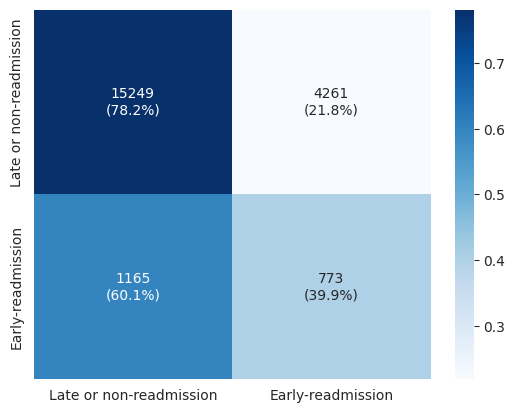

In [38]:
# Visualize confusion matrix with both absolute and percentage values
cm_rus = confusion_matrix(y_test, y_test_pred_rus)
cm_rus_norm = confusion_matrix(y_test, y_test_pred_rus, normalize='true')

annotations_rus = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_rus, cm_rus_norm)
])

sns.heatmap(
    cm_rus_norm,
    annot=annotations_rus,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **4. Optuna Hyper-parameter Tuning | SMOTE**
Hyper-parameter tuning of the model using Optuna, and oversampling with SMOTE.

### 4.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [39]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter suggestions
    hidden_layers = [trial.suggest_int(f"n_units_l{i}", 16, 128, step=8) for i in range(trial.suggest_int("n_layers", 1, 3))]
    dropouts = [trial.suggest_float(f"dropout_l{i}", 0.0, 0.5, step=0.05) for i in range(len(hidden_layers))]
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    optimizer_name = trial.suggest_categorical("optimizer", ['adam', 'sgd', 'rmsprop'])
    
    # Creating the activation function
    activation_name = trial.suggest_categorical("activation", ['relu', 'selu', 'tanh', 'sigmoid'])
    activation_dict = {
        'relu': nn.ReLU,
        'selu': nn.SELU,
        'tanh': nn.Tanh,
        'sigmoid': nn.Sigmoid
    }
    activation_fn = activation_dict[activation_name]()
    
    # Loading the optimizer
    optimizer_dict = {
        'adam': torch.optim.Adam,
        'sgd': torch.optim.SGD,
        'rmsprop': torch.optim.RMSprop
    }
    optimizer_fn = optimizer_dict[optimizer_name]
    
    # Sampling strategy
    sampler = SMOTE(random_state=RANDOM_STATE)
    
    # Stratified K-Fold setup
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        # Get the current fold
        X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        # Apply Random Under-Sampling
        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_fold, y_train_fold)
        
        # Convert dataset to tensors
        X_train_tensor = torch.tensor(X_train_resampled.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val_fold.values, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val_fold.values, dtype=torch.long)
        
        # Create dataloaders for the current fold
        train_loader = DataLoader(DiabeticDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(DiabeticDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
        
        # Create a new model instance for each fold
        model = NN(
            input_size=X_train.shape[1],
            hidden_layers=hidden_layers,
            activation_fn=activation_fn,
            dropouts=dropouts,
            output_size=NUM_CLASSES
        ).to(DEVICE)
        
        # Compile the model
        optimizer = optimizer_fn(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
        model.compile(optimizer, criterion)

        # Train and validate the model
        f1, _ = model.fit(
            train_loader,
            val_loader,
            DEVICE,
            patience=PATIENCE,
            max_epochs=EPOCHS
        )
        scores.append(f1)

    # Return the average F1-Macro score across all folds
    f1_mean = sum(scores) / len(scores)
    print("Cross validation scores: {}".format(list(map(lambda x: round(float(x), 6), scores))))
    print("Average score: {}".format(f1_mean))
    
    return f1_mean

In [40]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-23 07:48:29,535] Using an existing study with name 'Diabetes_130-US' instead of creating a new one.


### 4.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [ ]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=1 # GPU can only support one job per time
)

 22%|██▏       | 43/200 [01:14<04:33,  1.74s/it]
[I 2025-01-22 16:31:04,372] Trial 0 finished with value: 0.5401457563388078 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 128, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.30000000000000004, 'lr': 0.0026536590823549467, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 0 with value: 0.5401457563388078.


Cross validation scores: [0.546046, 0.545432, 0.549713, 0.530692, 0.528846]
Average score: 0.5401457563388078


 18%|█▊        | 37/200 [01:13<05:23,  1.98s/it]
[I 2025-01-22 16:36:42,391] Trial 1 finished with value: 0.5451002569997405 and parameters: {'n_layers': 3, 'n_units_l0': 72, 'n_units_l1': 112, 'n_units_l2': 128, 'dropout_l0': 0.45, 'dropout_l1': 0.15000000000000002, 'dropout_l2': 0.30000000000000004, 'lr': 0.004156363540430432, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 1 with value: 0.5451002569997405.


Cross validation scores: [0.545711, 0.549527, 0.550584, 0.549363, 0.530316]
Average score: 0.5451002569997405


  8%|▊         | 17/200 [00:25<04:38,  1.52s/it]
[I 2025-01-22 16:38:54,255] Trial 2 finished with value: 0.5226903787203492 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 16, 'dropout_l0': 0.1, 'dropout_l1': 0.2, 'lr': 0.0024751269602064094, 'batch_size': 32, 'optimizer': 'sgd', 'activation': 'selu'}. Best is trial 1 with value: 0.5451002569997405.


Cross validation scores: [0.52084, 0.530218, 0.525222, 0.522576, 0.514596]
Average score: 0.5226903787203492


  8%|▊         | 15/200 [00:09<01:56,  1.58it/s]
[I 2025-01-22 16:39:47,563] Trial 3 finished with value: 0.5382371191036042 and parameters: {'n_layers': 2, 'n_units_l0': 56, 'n_units_l1': 40, 'dropout_l0': 0.2, 'dropout_l1': 0.30000000000000004, 'lr': 0.0002078883867918235, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 1 with value: 0.5451002569997405.


Cross validation scores: [0.544072, 0.531791, 0.548718, 0.523278, 0.543327]
Average score: 0.5382371191036042


  8%|▊         | 15/200 [00:24<05:06,  1.66s/it]
[I 2025-01-22 16:42:23,800] Trial 4 finished with value: 0.5273226738862947 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 16, 'dropout_l0': 0.25, 'dropout_l1': 0.25, 'lr': 0.0036906476729552783, 'batch_size': 32, 'optimizer': 'sgd', 'activation': 'selu'}. Best is trial 1 with value: 0.5451002569997405.


Cross validation scores: [0.537579, 0.523801, 0.527624, 0.527427, 0.520182]
Average score: 0.5273226738862947


  8%|▊         | 17/200 [00:30<05:26,  1.78s/it]
[I 2025-01-22 16:45:11,164] Trial 5 finished with value: 0.5223119759048037 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 56, 'dropout_l0': 0.45, 'dropout_l1': 0.45, 'lr': 7.750283070716948e-05, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 1 with value: 0.5451002569997405.


Cross validation scores: [0.520813, 0.529477, 0.523211, 0.528845, 0.509214]
Average score: 0.5223119759048037


 16%|█▋        | 33/200 [00:18<01:31,  1.82it/s]
[I 2025-01-22 16:46:45,747] Trial 6 finished with value: 0.5463086743185983 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 88, 'dropout_l0': 0.15000000000000002, 'dropout_l1': 0.05, 'lr': 0.09905695041134392, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 6 with value: 0.5463086743185983.


Cross validation scores: [0.540136, 0.546821, 0.554603, 0.549172, 0.540812]
Average score: 0.5463086743185983


 12%|█▎        | 25/200 [00:25<02:59,  1.02s/it]
[I 2025-01-22 16:48:56,832] Trial 7 finished with value: 0.5438285945340228 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 104, 'dropout_l0': 0.4, 'dropout_l1': 0.45, 'lr': 0.012590518424726376, 'batch_size': 64, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 6 with value: 0.5463086743185983.


Cross validation scores: [0.550977, 0.549147, 0.553071, 0.533394, 0.532553]
Average score: 0.5438285945340228


 15%|█▌        | 30/200 [01:42<09:43,  3.43s/it]
[I 2025-01-22 16:57:44,694] Trial 8 finished with value: 0.5397839301646339 and parameters: {'n_layers': 3, 'n_units_l0': 96, 'n_units_l1': 96, 'n_units_l2': 72, 'dropout_l0': 0.2, 'dropout_l1': 0.5, 'dropout_l2': 0.30000000000000004, 'lr': 0.001375981904050833, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 6 with value: 0.5463086743185983.


Cross validation scores: [0.538546, 0.534226, 0.542073, 0.548742, 0.535332]
Average score: 0.5397839301646339


 19%|█▉        | 38/200 [00:24<01:46,  1.52it/s]
[I 2025-01-22 16:59:23,973] Trial 9 finished with value: 0.5363852505271882 and parameters: {'n_layers': 3, 'n_units_l0': 48, 'n_units_l1': 120, 'n_units_l2': 96, 'dropout_l0': 0.1, 'dropout_l1': 0.4, 'dropout_l2': 0.1, 'lr': 0.028222548122153395, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 6 with value: 0.5463086743185983.


Cross validation scores: [0.544046, 0.476352, 0.561279, 0.554149, 0.546099]
Average score: 0.5363852505271882


  8%|▊         | 16/200 [00:07<01:30,  2.04it/s]
[I 2025-01-22 17:00:20,970] Trial 10 finished with value: 0.5416457853860996 and parameters: {'n_layers': 1, 'n_units_l0': 16, 'dropout_l0': 0.0, 'lr': 0.08419051856633127, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 6 with value: 0.5463086743185983.


Cross validation scores: [0.541638, 0.546404, 0.54649, 0.538135, 0.535562]
Average score: 0.5416457853860996


  8%|▊         | 16/200 [00:15<02:59,  1.03it/s]
[I 2025-01-22 17:01:52,393] Trial 11 finished with value: 0.5326979370737575 and parameters: {'n_layers': 3, 'n_units_l0': 88, 'n_units_l1': 80, 'n_units_l2': 128, 'dropout_l0': 0.5, 'dropout_l1': 0.0, 'dropout_l2': 0.5, 'lr': 0.09188030274448399, 'batch_size': 64, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 6 with value: 0.5463086743185983.


Cross validation scores: [0.526971, 0.540437, 0.546127, 0.519935, 0.53002]
Average score: 0.5326979370737575


 16%|█▋        | 33/200 [01:21<06:53,  2.47s/it]
[I 2025-01-22 17:08:42,356] Trial 12 finished with value: 0.51850455304057 and parameters: {'n_layers': 1, 'n_units_l0': 32, 'dropout_l0': 0.35000000000000003, 'lr': 1.0613565497819229e-05, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 6 with value: 0.5463086743185983.


Cross validation scores: [0.509909, 0.527851, 0.531865, 0.510274, 0.512624]
Average score: 0.51850455304057


  8%|▊         | 15/200 [00:09<01:53,  1.63it/s]
[I 2025-01-22 17:09:33,523] Trial 13 finished with value: 0.48366448104547566 and parameters: {'n_layers': 3, 'n_units_l0': 80, 'n_units_l1': 88, 'n_units_l2': 24, 'dropout_l0': 0.1, 'dropout_l1': 0.05, 'dropout_l2': 0.30000000000000004, 'lr': 0.013365341046317439, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 6 with value: 0.5463086743185983.


Cross validation scores: [0.476352, 0.476352, 0.512968, 0.476325, 0.476325]
Average score: 0.48366448104547566


  8%|▊         | 15/200 [00:23<04:44,  1.54s/it]
[I 2025-01-22 17:11:35,130] Trial 14 finished with value: 0.5172817495164332 and parameters: {'n_layers': 1, 'n_units_l0': 40, 'dropout_l0': 0.30000000000000004, 'lr': 0.0002961074394831766, 'batch_size': 32, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 6 with value: 0.5463086743185983.


Cross validation scores: [0.512881, 0.523513, 0.524334, 0.512636, 0.513045]
Average score: 0.5172817495164332


 13%|█▎        | 26/200 [00:16<01:51,  1.57it/s]
[I 2025-01-22 17:13:19,623] Trial 15 finished with value: 0.5518656247971316 and parameters: {'n_layers': 3, 'n_units_l0': 72, 'n_units_l1': 112, 'n_units_l2': 128, 'dropout_l0': 0.5, 'dropout_l1': 0.1, 'dropout_l2': 0.5, 'lr': 0.00967410192391911, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.551725, 0.562608, 0.553637, 0.547358, 0.544001]
Average score: 0.5518656247971316


  8%|▊         | 17/200 [00:10<01:48,  1.69it/s]
[I 2025-01-22 17:14:08,395] Trial 16 finished with value: 0.47633597337075617 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 72, 'dropout_l0': 0.0, 'dropout_l1': 0.1, 'dropout_l2': 0.5, 'lr': 0.027276476928534372, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


  8%|▊         | 17/200 [00:08<01:30,  2.02it/s]
[I 2025-01-22 17:15:28,067] Trial 17 finished with value: 0.5461404045024255 and parameters: {'n_layers': 1, 'n_units_l0': 80, 'dropout_l0': 0.2, 'lr': 0.012172369759580963, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.546281, 0.549819, 0.551311, 0.539117, 0.544175]
Average score: 0.5461404045024255


 10%|█         | 20/200 [00:11<01:44,  1.73it/s]
[I 2025-01-22 17:16:55,371] Trial 18 finished with value: 0.5403074008818229 and parameters: {'n_layers': 2, 'n_units_l0': 104, 'n_units_l1': 80, 'dropout_l0': 0.5, 'dropout_l1': 0.0, 'lr': 0.03708743180011666, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.550229, 0.528264, 0.553871, 0.550983, 0.518189]
Average score: 0.5403074008818229


  9%|▉         | 18/200 [00:11<01:52,  1.62it/s]
[I 2025-01-22 17:18:09,908] Trial 19 finished with value: 0.5281632630276527 and parameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 104, 'dropout_l0': 0.15000000000000002, 'dropout_l1': 0.1, 'lr': 0.007081566675293643, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.527415, 0.532323, 0.5364, 0.525016, 0.519662]
Average score: 0.5281632630276527


 10%|█         | 20/200 [01:06<09:56,  3.32s/it]
[I 2025-01-22 17:24:54,928] Trial 20 finished with value: 0.5226014619656028 and parameters: {'n_layers': 3, 'n_units_l0': 24, 'n_units_l1': 128, 'n_units_l2': 24, 'dropout_l0': 0.30000000000000004, 'dropout_l1': 0.15000000000000002, 'dropout_l2': 0.0, 'lr': 0.0006398665323776514, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.528897, 0.533936, 0.52587, 0.511327, 0.512977]
Average score: 0.5226014619656028


 19%|█▉        | 38/200 [00:18<01:17,  2.09it/s]
[I 2025-01-22 17:25:51,488] Trial 21 finished with value: 0.5487801702792974 and parameters: {'n_layers': 1, 'n_units_l0': 80, 'dropout_l0': 0.2, 'lr': 0.011802858798793447, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.55074, 0.551804, 0.554672, 0.543871, 0.542813]
Average score: 0.5487801702792974


 10%|▉         | 19/200 [00:09<01:28,  2.04it/s]
[I 2025-01-22 17:26:52,688] Trial 22 finished with value: 0.5446525057782065 and parameters: {'n_layers': 1, 'n_units_l0': 72, 'dropout_l0': 0.15000000000000002, 'lr': 0.03341768823371135, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.544248, 0.54162, 0.551698, 0.542087, 0.543609]
Average score: 0.5446525057782065


 12%|█▎        | 25/200 [00:12<01:24,  2.07it/s]
[I 2025-01-22 17:27:59,007] Trial 23 finished with value: 0.5438714171700405 and parameters: {'n_layers': 1, 'n_units_l0': 88, 'dropout_l0': 0.25, 'lr': 0.06198644621941582, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.543372, 0.546429, 0.550409, 0.54032, 0.538827]
Average score: 0.5438714171700405


  9%|▉         | 18/200 [00:13<02:13,  1.36it/s]
[I 2025-01-22 17:29:18,413] Trial 24 finished with value: 0.5242777328257537 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout_l0': 0.05, 'lr': 0.008582741080499192, 'batch_size': 64, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.524222, 0.531186, 0.528309, 0.519113, 0.518558]
Average score: 0.5242777328257537


 12%|█▎        | 25/200 [00:13<01:34,  1.86it/s]
[I 2025-01-22 17:31:23,295] Trial 25 finished with value: 0.5227187721714399 and parameters: {'n_layers': 2, 'n_units_l0': 48, 'n_units_l1': 48, 'dropout_l0': 0.15000000000000002, 'dropout_l1': 0.05, 'lr': 0.000979301691388169, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.531137, 0.534349, 0.499393, 0.536606, 0.512108]
Average score: 0.5227187721714399


  9%|▉         | 18/200 [00:09<01:31,  1.99it/s]
[I 2025-01-22 17:32:38,552] Trial 26 finished with value: 0.5464910700012852 and parameters: {'n_layers': 1, 'n_units_l0': 80, 'dropout_l0': 0.30000000000000004, 'lr': 0.01695241405701382, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.543478, 0.546649, 0.552026, 0.545727, 0.544575]
Average score: 0.5464910700012852


 10%|█         | 20/200 [00:09<01:26,  2.08it/s]
[I 2025-01-22 17:33:33,422] Trial 27 finished with value: 0.544493591781829 and parameters: {'n_layers': 1, 'n_units_l0': 72, 'dropout_l0': 0.35000000000000003, 'lr': 0.005941638146217008, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.544287, 0.549518, 0.545225, 0.539073, 0.544365]
Average score: 0.544493591781829


 29%|██▉       | 58/200 [00:31<01:16,  1.86it/s]
[I 2025-01-22 17:35:08,348] Trial 28 finished with value: 0.5300849795250843 and parameters: {'n_layers': 1, 'n_units_l0': 88, 'dropout_l0': 0.30000000000000004, 'lr': 0.02207964219575209, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.538163, 0.527086, 0.536785, 0.522814, 0.525577]
Average score: 0.5300849795250843


 10%|█         | 21/200 [00:53<07:31,  2.52s/it]
[I 2025-01-22 17:39:00,001] Trial 29 finished with value: 0.5348203561865976 and parameters: {'n_layers': 1, 'n_units_l0': 112, 'dropout_l0': 0.4, 'lr': 0.0025576133788990218, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.528815, 0.537407, 0.544581, 0.537253, 0.526047]
Average score: 0.5348203561865976


 10%|█         | 21/200 [00:17<02:25,  1.23it/s]
[I 2025-01-22 17:40:36,644] Trial 30 finished with value: 0.542750518173755 and parameters: {'n_layers': 1, 'n_units_l0': 56, 'dropout_l0': 0.35000000000000003, 'lr': 0.01694988678620337, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.53281, 0.552058, 0.560558, 0.537705, 0.530622]
Average score: 0.542750518173755


 20%|█▉        | 39/200 [00:20<01:24,  1.91it/s]
[I 2025-01-22 17:42:30,403] Trial 31 finished with value: 0.5445934428039044 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 72, 'dropout_l0': 0.2, 'dropout_l1': 0.2, 'lr': 0.03953786681688655, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.541379, 0.545247, 0.552714, 0.543901, 0.539725]
Average score: 0.5445934428039044


 12%|█▏        | 24/200 [00:13<01:37,  1.81it/s]
[I 2025-01-22 17:44:04,723] Trial 32 finished with value: 0.5446058535992977 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 96, 'dropout_l0': 0.25, 'dropout_l1': 0.1, 'lr': 0.05774839128646249, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.543447, 0.537546, 0.552456, 0.545087, 0.544493]
Average score: 0.5446058535992977


  8%|▊         | 16/200 [00:09<01:48,  1.69it/s]
[I 2025-01-22 17:44:51,668] Trial 33 finished with value: 0.47633597337075617 and parameters: {'n_layers': 3, 'n_units_l0': 80, 'n_units_l1': 112, 'n_units_l2': 96, 'dropout_l0': 0.45, 'dropout_l1': 0.0, 'dropout_l2': 0.4, 'lr': 0.004201974865631676, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


  8%|▊         | 17/200 [00:09<01:42,  1.79it/s]
[I 2025-01-22 17:46:01,233] Trial 34 finished with value: 0.503685040517591 and parameters: {'n_layers': 2, 'n_units_l0': 72, 'n_units_l1': 88, 'dropout_l0': 0.05, 'dropout_l1': 0.05, 'lr': 0.0020280115258095644, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.476352, 0.476352, 0.550563, 0.530198, 0.484959]
Average score: 0.503685040517591


 13%|█▎        | 26/200 [00:12<01:23,  2.07it/s]
[I 2025-01-22 17:47:06,203] Trial 35 finished with value: 0.5474299124529192 and parameters: {'n_layers': 1, 'n_units_l0': 104, 'dropout_l0': 0.15000000000000002, 'lr': 0.00819456792925077, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.548508, 0.5467, 0.551443, 0.54496, 0.545539]
Average score: 0.5474299124529192


 12%|█▏        | 24/200 [00:34<04:11,  1.43s/it]
[I 2025-01-22 17:50:00,126] Trial 36 finished with value: 0.5488190686169379 and parameters: {'n_layers': 1, 'n_units_l0': 104, 'dropout_l0': 0.4, 'lr': 0.005090433313980467, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.545723, 0.560492, 0.5534, 0.547218, 0.537263]
Average score: 0.5488190686169379


 22%|██▏       | 44/200 [01:01<03:38,  1.40s/it]
[I 2025-01-22 17:53:12,228] Trial 37 finished with value: 0.5442180453084868 and parameters: {'n_layers': 1, 'n_units_l0': 120, 'dropout_l0': 0.4, 'lr': 0.005354322212568193, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.539493, 0.553937, 0.548764, 0.541386, 0.537509]
Average score: 0.5442180453084868


 13%|█▎        | 26/200 [00:36<04:05,  1.41s/it]
[I 2025-01-22 17:56:59,429] Trial 38 finished with value: 0.5478520491141843 and parameters: {'n_layers': 1, 'n_units_l0': 120, 'dropout_l0': 0.45, 'lr': 0.0035677396398166574, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.54513, 0.553694, 0.551844, 0.548414, 0.540178]
Average score: 0.5478520491141843


 12%|█▎        | 25/200 [00:35<04:10,  1.43s/it]
[I 2025-01-22 17:59:58,940] Trial 39 finished with value: 0.5405514270090659 and parameters: {'n_layers': 1, 'n_units_l0': 120, 'dropout_l0': 0.45, 'lr': 0.0015791259867399135, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.540514, 0.548291, 0.54449, 0.535033, 0.534429]
Average score: 0.5405514270090659


 17%|█▋        | 34/200 [00:47<03:53,  1.41s/it]
[I 2025-01-22 18:02:53,233] Trial 40 finished with value: 0.5476356478762533 and parameters: {'n_layers': 1, 'n_units_l0': 104, 'dropout_l0': 0.5, 'lr': 0.00332622573081274, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.544517, 0.553726, 0.556691, 0.550521, 0.532723]
Average score: 0.5476356478762533


 14%|█▍        | 29/200 [00:40<04:01,  1.41s/it]
[I 2025-01-22 18:05:48,444] Trial 41 finished with value: 0.545549809729299 and parameters: {'n_layers': 1, 'n_units_l0': 104, 'dropout_l0': 0.5, 'lr': 0.0032657063814018434, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.541458, 0.547628, 0.560629, 0.546882, 0.531152]
Average score: 0.545549809729299


 14%|█▍        | 29/200 [00:40<04:01,  1.41s/it]
[I 2025-01-22 18:08:41,172] Trial 42 finished with value: 0.5317756581506974 and parameters: {'n_layers': 1, 'n_units_l0': 120, 'dropout_l0': 0.5, 'lr': 0.0007275679603807856, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.536152, 0.540576, 0.53658, 0.524946, 0.520624]
Average score: 0.5317756581506974


 10%|█         | 21/200 [00:30<04:18,  1.44s/it]
[I 2025-01-22 18:11:54,622] Trial 43 finished with value: 0.5468181047719165 and parameters: {'n_layers': 1, 'n_units_l0': 112, 'dropout_l0': 0.45, 'lr': 0.004306114440851214, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.545753, 0.547804, 0.552698, 0.554201, 0.533635]
Average score: 0.5468181047719165


  8%|▊         | 17/200 [00:24<04:27,  1.46s/it]
[I 2025-01-22 18:14:41,075] Trial 44 finished with value: 0.54512954441809 and parameters: {'n_layers': 1, 'n_units_l0': 104, 'dropout_l0': 0.5, 'lr': 0.002526617507305868, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.545494, 0.545726, 0.551935, 0.547338, 0.535156]
Average score: 0.54512954441809


 16%|█▌        | 31/200 [00:43<03:58,  1.41s/it]
[I 2025-01-22 18:17:50,965] Trial 45 finished with value: 0.5413657125404993 and parameters: {'n_layers': 1, 'n_units_l0': 96, 'dropout_l0': 0.4, 'lr': 0.0017659030762771286, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.540442, 0.55496, 0.539741, 0.541665, 0.53002]
Average score: 0.5413657125404993


 12%|█▎        | 25/200 [00:35<04:10,  1.43s/it]
[I 2025-01-22 18:21:28,667] Trial 46 finished with value: 0.524715826279514 and parameters: {'n_layers': 1, 'n_units_l0': 120, 'dropout_l0': 0.45, 'lr': 0.00042135225132946473, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.524063, 0.530844, 0.533563, 0.522426, 0.512683]
Average score: 0.524715826279514


  8%|▊         | 16/200 [00:26<05:10,  1.69s/it]
[I 2025-01-22 18:23:56,758] Trial 47 finished with value: 0.5211593999875281 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 32, 'dropout_l0': 0.5, 'dropout_l1': 0.35000000000000003, 'lr': 0.0001098711770043576, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.517535, 0.525963, 0.529157, 0.516277, 0.516865]
Average score: 0.5211593999875281


  8%|▊         | 15/200 [00:21<04:30,  1.46s/it]
[I 2025-01-22 18:26:06,718] Trial 48 finished with value: 0.5475347279240529 and parameters: {'n_layers': 1, 'n_units_l0': 88, 'dropout_l0': 0.4, 'lr': 0.010658935674912277, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.55472, 0.553083, 0.543988, 0.546729, 0.539153]
Average score: 0.5475347279240529


  8%|▊         | 15/200 [00:29<05:58,  1.94s/it]
[I 2025-01-22 18:28:49,484] Trial 49 finished with value: 0.5185128716681298 and parameters: {'n_layers': 3, 'n_units_l0': 112, 'n_units_l1': 64, 'n_units_l2': 48, 'dropout_l0': 0.45, 'dropout_l1': 0.25, 'dropout_l2': 0.15000000000000002, 'lr': 1.8734794275790498e-05, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.511092, 0.515362, 0.526493, 0.519981, 0.519636]
Average score: 0.5185128716681298


 20%|█▉        | 39/200 [00:57<03:56,  1.47s/it]
[I 2025-01-22 18:32:11,998] Trial 50 finished with value: 0.5294286218891681 and parameters: {'n_layers': 1, 'n_units_l0': 128, 'dropout_l0': 0.45, 'lr': 0.0010878930418653386, 'batch_size': 32, 'optimizer': 'adam', 'activation': 'selu'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.526526, 0.533616, 0.536297, 0.532446, 0.518258]
Average score: 0.5294286218891681


 16%|█▌        | 31/200 [00:44<04:01,  1.43s/it]
[I 2025-01-22 18:35:24,357] Trial 51 finished with value: 0.5446667515914732 and parameters: {'n_layers': 1, 'n_units_l0': 88, 'dropout_l0': 0.4, 'lr': 0.01084395771207639, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.537797, 0.548569, 0.555648, 0.543316, 0.538003]
Average score: 0.5446667515914732


  9%|▉         | 18/200 [00:25<04:21,  1.44s/it]
[I 2025-01-22 18:38:49,251] Trial 52 finished with value: 0.5310985328796537 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout_l0': 0.35000000000000003, 'lr': 0.005171701382759547, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.520334, 0.534837, 0.538357, 0.524336, 0.537628]
Average score: 0.5310985328796537


  8%|▊         | 16/200 [00:23<04:27,  1.45s/it]
[I 2025-01-22 18:41:38,016] Trial 53 finished with value: 0.5434677950474596 and parameters: {'n_layers': 1, 'n_units_l0': 88, 'dropout_l0': 0.4, 'lr': 0.009760989164611078, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.546508, 0.550114, 0.550678, 0.53466, 0.535378]
Average score: 0.5434677950474596


 22%|██▏       | 43/200 [01:47<06:31,  2.49s/it]
[I 2025-01-22 18:47:23,548] Trial 54 finished with value: 0.530000664807874 and parameters: {'n_layers': 1, 'n_units_l0': 96, 'dropout_l0': 0.5, 'lr': 0.0035546378574189234, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 15 with value: 0.5518656247971316.


Cross validation scores: [0.526332, 0.528347, 0.52882, 0.540521, 0.525983]
Average score: 0.530000664807874


 19%|█▉        | 38/200 [00:30<02:11,  1.23it/s]
[I 2025-01-22 18:49:35,229] Trial 55 finished with value: 0.5566981405771392 and parameters: {'n_layers': 1, 'n_units_l0': 104, 'dropout_l0': 0.45, 'lr': 0.018070616763307408, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.555238, 0.558867, 0.556936, 0.550532, 0.561917]
Average score: 0.5566981405771392


 14%|█▍        | 28/200 [00:22<02:18,  1.24it/s]
[I 2025-01-22 18:51:27,580] Trial 56 finished with value: 0.5454580679667392 and parameters: {'n_layers': 1, 'n_units_l0': 104, 'dropout_l0': 0.5, 'lr': 0.017701821744505245, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.535713, 0.549786, 0.556708, 0.545514, 0.539569]
Average score: 0.5454580679667392


 14%|█▍        | 28/200 [00:26<02:44,  1.05it/s]
[I 2025-01-22 18:53:43,522] Trial 57 finished with value: 0.548669274815652 and parameters: {'n_layers': 2, 'n_units_l0': 56, 'n_units_l1': 120, 'dropout_l0': 0.25, 'dropout_l1': 0.2, 'lr': 0.006879779751748566, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.549342, 0.54854, 0.551373, 0.547652, 0.546438]
Average score: 0.548669274815652


 13%|█▎        | 26/200 [00:25<02:48,  1.03it/s]
[I 2025-01-22 18:56:05,459] Trial 58 finished with value: 0.5259510605861444 and parameters: {'n_layers': 2, 'n_units_l0': 48, 'n_units_l1': 120, 'dropout_l0': 0.25, 'dropout_l1': 0.2, 'lr': 0.0068122429391222206, 'batch_size': 64, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.514273, 0.526277, 0.547588, 0.519734, 0.521884]
Average score: 0.5259510605861444


  8%|▊         | 15/200 [00:16<03:21,  1.09s/it]
[I 2025-01-22 18:57:31,516] Trial 59 finished with value: 0.47633597337075617 and parameters: {'n_layers': 3, 'n_units_l0': 56, 'n_units_l1': 112, 'n_units_l2': 104, 'dropout_l0': 0.2, 'dropout_l1': 0.15000000000000002, 'dropout_l2': 0.4, 'lr': 0.023244975847911506, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


  8%|▊         | 17/200 [00:16<02:56,  1.04it/s]
[I 2025-01-22 18:58:51,316] Trial 60 finished with value: 0.5302936287874036 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 128, 'dropout_l0': 0.25, 'dropout_l1': 0.30000000000000004, 'lr': 0.05104417711843334, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.52761, 0.545889, 0.52953, 0.545071, 0.503367]
Average score: 0.5302936287874036


 14%|█▎        | 27/200 [00:28<03:03,  1.06s/it]
[I 2025-01-22 19:00:54,068] Trial 61 finished with value: 0.5377979520999496 and parameters: {'n_layers': 3, 'n_units_l0': 40, 'n_units_l1': 128, 'n_units_l2': 72, 'dropout_l0': 0.45, 'dropout_l1': 0.35000000000000003, 'dropout_l2': 0.2, 'lr': 0.014529701114340494, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.53281, 0.538828, 0.560561, 0.52878, 0.528011]
Average score: 0.5377979520999496


  9%|▉         | 18/200 [00:14<02:30,  1.21it/s]
[I 2025-01-22 19:02:34,041] Trial 62 finished with value: 0.5400285906488793 and parameters: {'n_layers': 1, 'n_units_l0': 112, 'dropout_l0': 0.5, 'lr': 0.007065879591642297, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.535158, 0.552403, 0.549008, 0.531263, 0.532311]
Average score: 0.5400285906488793


  8%|▊         | 17/200 [00:14<02:33,  1.19it/s]
[I 2025-01-22 19:04:14,802] Trial 63 finished with value: 0.5439891856086797 and parameters: {'n_layers': 1, 'n_units_l0': 40, 'dropout_l0': 0.45, 'lr': 0.0032773504132117782, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.543239, 0.554547, 0.546481, 0.547416, 0.528263]
Average score: 0.5439891856086797


 10%|█         | 20/200 [00:18<02:49,  1.06it/s]
[I 2025-01-22 19:06:32,505] Trial 64 finished with value: 0.5442455176546585 and parameters: {'n_layers': 2, 'n_units_l0': 56, 'n_units_l1': 120, 'dropout_l0': 0.2, 'dropout_l1': 0.2, 'lr': 0.005223928124068428, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.539045, 0.552199, 0.555422, 0.539865, 0.534697]
Average score: 0.5442455176546585


  8%|▊         | 16/200 [00:55<10:36,  3.46s/it]
[I 2025-01-22 19:11:07,532] Trial 65 finished with value: 0.47633597337075617 and parameters: {'n_layers': 3, 'n_units_l0': 72, 'n_units_l1': 104, 'n_units_l2': 112, 'dropout_l0': 0.45, 'dropout_l1': 0.30000000000000004, 'dropout_l2': 0.4, 'lr': 0.02274331224932074, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


 15%|█▌        | 30/200 [00:24<02:16,  1.25it/s]
[I 2025-01-22 19:12:38,961] Trial 66 finished with value: 0.5317886830625633 and parameters: {'n_layers': 1, 'n_units_l0': 104, 'dropout_l0': 0.1, 'lr': 0.0021082351230323755, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.531523, 0.535088, 0.54306, 0.521108, 0.528165]
Average score: 0.5317886830625633


 18%|█▊        | 35/200 [00:34<02:41,  1.02it/s]
[I 2025-01-22 19:15:10,203] Trial 67 finished with value: 0.5485962236451136 and parameters: {'n_layers': 1, 'n_units_l0': 128, 'dropout_l0': 0.5, 'lr': 0.013083075932091327, 'batch_size': 64, 'optimizer': 'adam', 'activation': 'selu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.547962, 0.554623, 0.564249, 0.543687, 0.53246]
Average score: 0.5485962236451136


 10%|▉         | 19/200 [00:21<03:27,  1.15s/it]
[I 2025-01-22 19:16:49,053] Trial 68 finished with value: 0.5374153027815451 and parameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 96, 'dropout_l0': 0.25, 'dropout_l1': 0.15000000000000002, 'lr': 0.014095790459707337, 'batch_size': 64, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.530631, 0.545227, 0.544203, 0.539961, 0.527055]
Average score: 0.5374153027815451


 24%|██▍       | 49/200 [00:45<02:20,  1.07it/s]
[I 2025-01-22 19:18:57,243] Trial 69 finished with value: 0.5453199101920354 and parameters: {'n_layers': 1, 'n_units_l0': 120, 'dropout_l0': 0.30000000000000004, 'lr': 0.030014317237262382, 'batch_size': 64, 'optimizer': 'adam', 'activation': 'selu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.540851, 0.554726, 0.549646, 0.526126, 0.555251]
Average score: 0.5453199101920354


  8%|▊         | 16/200 [00:14<02:43,  1.12it/s]
[I 2025-01-22 19:20:22,496] Trial 70 finished with value: 0.542399439166008 and parameters: {'n_layers': 1, 'n_units_l0': 128, 'dropout_l0': 0.45, 'lr': 0.008559626037526843, 'batch_size': 64, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.532114, 0.546194, 0.54357, 0.549438, 0.540681]
Average score: 0.542399439166008


 12%|█▏        | 24/200 [00:21<02:36,  1.12it/s]
[I 2025-01-22 19:22:00,276] Trial 71 finished with value: 0.545502058251011 and parameters: {'n_layers': 1, 'n_units_l0': 112, 'dropout_l0': 0.5, 'lr': 0.011472560207107076, 'batch_size': 64, 'optimizer': 'adam', 'activation': 'selu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.541828, 0.558211, 0.554648, 0.540044, 0.532778]
Average score: 0.545502058251011


 14%|█▍        | 29/200 [00:16<01:38,  1.73it/s]
[I 2025-01-22 19:23:12,410] Trial 72 finished with value: 0.543738713301211 and parameters: {'n_layers': 1, 'n_units_l0': 120, 'dropout_l0': 0.5, 'lr': 0.018454304540582594, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'selu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.537626, 0.549931, 0.546526, 0.548042, 0.53657]
Average score: 0.543738713301211


 14%|█▎        | 27/200 [00:24<02:36,  1.11it/s]
[I 2025-01-22 19:25:12,243] Trial 73 finished with value: 0.5458624759153259 and parameters: {'n_layers': 1, 'n_units_l0': 96, 'dropout_l0': 0.5, 'lr': 0.0068198145890139596, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.54557, 0.550048, 0.554872, 0.542883, 0.535939]
Average score: 0.5458624759153259


 10%|▉         | 19/200 [00:53<08:27,  2.80s/it]
[I 2025-01-22 19:30:52,057] Trial 74 finished with value: 0.5469157285578221 and parameters: {'n_layers': 1, 'n_units_l0': 128, 'dropout_l0': 0.45, 'lr': 0.004324581973244401, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.540762, 0.554015, 0.559185, 0.545789, 0.534828]
Average score: 0.5469157285578221


 17%|█▋        | 34/200 [00:19<01:35,  1.74it/s]
[I 2025-01-22 19:31:52,121] Trial 75 finished with value: 0.5409002169964754 and parameters: {'n_layers': 1, 'n_units_l0': 80, 'dropout_l0': 0.5, 'lr': 0.008619922870770973, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.543124, 0.540874, 0.547548, 0.543895, 0.529061]
Average score: 0.5409002169964754


 14%|█▍        | 28/200 [00:44<04:35,  1.60s/it]
[I 2025-01-22 19:35:24,685] Trial 76 finished with value: 0.5435315895595082 and parameters: {'n_layers': 1, 'n_units_l0': 48, 'dropout_l0': 0.2, 'lr': 0.0030498218081863194, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.538607, 0.545936, 0.551899, 0.547956, 0.533259]
Average score: 0.5435315895595082


 16%|█▋        | 33/200 [00:20<01:45,  1.59it/s]
[I 2025-01-22 19:36:45,416] Trial 77 finished with value: 0.5265331402178296 and parameters: {'n_layers': 1, 'n_units_l0': 112, 'dropout_l0': 0.15000000000000002, 'lr': 0.005225975693551003, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.523891, 0.538034, 0.532954, 0.519735, 0.518053]
Average score: 0.5265331402178296


  8%|▊         | 15/200 [00:21<04:24,  1.43s/it]
[I 2025-01-22 19:38:51,284] Trial 78 finished with value: 0.5251659465785551 and parameters: {'n_layers': 1, 'n_units_l0': 72, 'dropout_l0': 0.5, 'lr': 0.0011995668048202972, 'batch_size': 32, 'optimizer': 'sgd', 'activation': 'selu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.525645, 0.530311, 0.527988, 0.519401, 0.522485]
Average score: 0.5251659465785551


  8%|▊         | 15/200 [00:17<03:29,  1.13s/it]
[I 2025-01-22 19:40:57,053] Trial 79 finished with value: 0.5039877951797578 and parameters: {'n_layers': 2, 'n_units_l0': 16, 'n_units_l1': 120, 'dropout_l0': 0.4, 'dropout_l1': 0.25, 'lr': 0.040280698940892895, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.553379, 0.476352, 0.476325, 0.537558, 0.476325]
Average score: 0.5039877951797578


 10%|█         | 20/200 [00:14<02:13,  1.35it/s]
[I 2025-01-22 19:42:24,163] Trial 80 finished with value: 0.5418852058759419 and parameters: {'n_layers': 3, 'n_units_l0': 104, 'n_units_l1': 32, 'n_units_l2': 48, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.1, 'dropout_l2': 0.0, 'lr': 0.014399431614589172, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'selu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.529798, 0.541173, 0.549864, 0.552747, 0.535843]
Average score: 0.5418852058759419


  9%|▉         | 18/200 [00:25<04:15,  1.40s/it]
[I 2025-01-22 19:45:09,978] Trial 81 finished with value: 0.5409311783613266 and parameters: {'n_layers': 1, 'n_units_l0': 88, 'dropout_l0': 0.4, 'lr': 0.011310013962969444, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.541349, 0.53288, 0.557459, 0.536675, 0.536293]
Average score: 0.5409311783613266


 10%|▉         | 19/200 [00:28<04:30,  1.49s/it]
[I 2025-01-22 19:47:55,289] Trial 82 finished with value: 0.537435436124411 and parameters: {'n_layers': 1, 'n_units_l0': 96, 'dropout_l0': 0.45, 'lr': 0.009451261393177077, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.530949, 0.541565, 0.549308, 0.528337, 0.537018]
Average score: 0.537435436124411


 16%|█▋        | 33/200 [00:46<03:55,  1.41s/it]
[I 2025-01-22 19:51:24,571] Trial 83 finished with value: 0.555941976216052 and parameters: {'n_layers': 1, 'n_units_l0': 80, 'dropout_l0': 0.4, 'lr': 0.01965753274523362, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.555328, 0.560653, 0.563286, 0.551324, 0.549118]
Average score: 0.555941976216052


 14%|█▍        | 28/200 [00:40<04:07,  1.44s/it]
[I 2025-01-22 19:54:47,849] Trial 84 finished with value: 0.554299220686328 and parameters: {'n_layers': 1, 'n_units_l0': 72, 'dropout_l0': 0.45, 'lr': 0.020310862444111788, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.55371, 0.561502, 0.558784, 0.551869, 0.545631]
Average score: 0.554299220686328


 10%|█         | 20/200 [00:25<03:51,  1.29s/it]
[I 2025-01-22 19:56:48,895] Trial 85 finished with value: 0.5378873596408599 and parameters: {'n_layers': 1, 'n_units_l0': 72, 'dropout_l0': 0.45, 'lr': 0.0758166733363836, 'batch_size': 32, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.542093, 0.536669, 0.547921, 0.533449, 0.529305]
Average score: 0.5378873596408599


 14%|█▍        | 28/200 [00:45<04:41,  1.64s/it]
[I 2025-01-22 20:00:04,704] Trial 86 finished with value: 0.5504336211569276 and parameters: {'n_layers': 1, 'n_units_l0': 80, 'dropout_l0': 0.4, 'lr': 0.023607767188662775, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.552531, 0.559374, 0.559509, 0.538968, 0.541786]
Average score: 0.5504336211569276


 10%|▉         | 19/200 [00:27<04:25,  1.47s/it]
[I 2025-01-22 20:04:11,194] Trial 87 finished with value: 0.5525578847396497 and parameters: {'n_layers': 1, 'n_units_l0': 80, 'dropout_l0': 0.4, 'lr': 0.027799385364089376, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.548037, 0.55639, 0.557988, 0.553775, 0.546599]
Average score: 0.5525578847396497


 16%|█▌        | 32/200 [00:45<03:58,  1.42s/it]
[I 2025-01-22 20:06:41,859] Trial 88 finished with value: 0.5490028420734951 and parameters: {'n_layers': 1, 'n_units_l0': 80, 'dropout_l0': 0.35000000000000003, 'lr': 0.0472962077282861, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.537749, 0.544186, 0.565887, 0.552166, 0.545026]
Average score: 0.5490028420734951


 12%|█▏        | 24/200 [00:38<04:45,  1.62s/it]
[I 2025-01-22 20:09:10,456] Trial 89 finished with value: 0.5528146181047262 and parameters: {'n_layers': 1, 'n_units_l0': 80, 'dropout_l0': 0.35000000000000003, 'lr': 0.04307600633054913, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.549323, 0.562297, 0.559894, 0.54787, 0.544689]
Average score: 0.5528146181047262


 11%|█         | 22/200 [00:34<04:37,  1.56s/it]
[I 2025-01-22 20:11:46,588] Trial 90 finished with value: 0.49230788636429895 and parameters: {'n_layers': 1, 'n_units_l0': 80, 'dropout_l0': 0.35000000000000003, 'lr': 0.06580491644834105, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.476352, 0.479695, 0.476325, 0.529968, 0.499199]
Average score: 0.49230788636429895


 18%|█▊        | 36/200 [00:59<04:31,  1.65s/it]
[I 2025-01-22 20:15:47,904] Trial 91 finished with value: 0.5524024350187312 and parameters: {'n_layers': 1, 'n_units_l0': 80, 'dropout_l0': 0.35000000000000003, 'lr': 0.049512953052676764, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.553654, 0.561026, 0.556201, 0.54043, 0.550701]
Average score: 0.5524024350187312


 10%|▉         | 19/200 [00:33<05:14,  1.74s/it]
[I 2025-01-22 20:18:55,504] Trial 92 finished with value: 0.5551194232801558 and parameters: {'n_layers': 1, 'n_units_l0': 80, 'dropout_l0': 0.35000000000000003, 'lr': 0.04611158011506784, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.546832, 0.55922, 0.558343, 0.552798, 0.558405]
Average score: 0.5551194232801558


 11%|█         | 22/200 [00:37<05:06,  1.72s/it]
[I 2025-01-22 20:21:36,756] Trial 93 finished with value: 0.5446027458826025 and parameters: {'n_layers': 1, 'n_units_l0': 80, 'dropout_l0': 0.35000000000000003, 'lr': 0.04820605015064169, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.548764, 0.535808, 0.559552, 0.550978, 0.527913]
Average score: 0.5446027458826025


 13%|█▎        | 26/200 [00:44<04:58,  1.71s/it]
[I 2025-01-22 20:25:49,232] Trial 94 finished with value: 0.5540215136683555 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout_l0': 0.30000000000000004, 'lr': 0.03521692030876935, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.550057, 0.554424, 0.564957, 0.554567, 0.546103]
Average score: 0.5540215136683555


 18%|█▊        | 35/200 [01:00<04:45,  1.73s/it]
[I 2025-01-22 20:29:09,765] Trial 95 finished with value: 0.551358534536854 and parameters: {'n_layers': 1, 'n_units_l0': 72, 'dropout_l0': 0.30000000000000004, 'lr': 0.03386270373166941, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.546613, 0.551961, 0.55584, 0.550842, 0.551536]
Average score: 0.551358534536854


  8%|▊         | 17/200 [00:30<05:24,  1.77s/it]
[I 2025-01-22 20:32:59,446] Trial 96 finished with value: 0.5541003818867664 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout_l0': 0.30000000000000004, 'lr': 0.03573208424768737, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.549586, 0.554769, 0.559667, 0.555962, 0.550519]
Average score: 0.5541003818867664


 10%|█         | 21/200 [00:35<05:02,  1.69s/it]
[I 2025-01-22 20:37:17,122] Trial 97 finished with value: 0.5564546264118345 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout_l0': 0.30000000000000004, 'lr': 0.027930280201718265, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.550713, 0.561944, 0.555331, 0.558237, 0.556048]
Average score: 0.5564546264118345


  8%|▊         | 16/200 [00:27<05:20,  1.74s/it]
[I 2025-01-22 20:40:14,602] Trial 98 finished with value: 0.47648729985219573 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout_l0': 0.35000000000000003, 'lr': 0.08958488339519376, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.477082, 0.476325]
Average score: 0.47648729985219573


 12%|█▏        | 23/200 [00:39<05:04,  1.72s/it]
[I 2025-01-22 20:43:54,647] Trial 99 finished with value: 0.5506478836553625 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout_l0': 0.30000000000000004, 'lr': 0.02831971406810198, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 55 with value: 0.5566981405771392.


Cross validation scores: [0.560074, 0.544963, 0.562763, 0.553018, 0.532421]
Average score: 0.5506478836553625


In [103]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 55
Best Parameters: {'n_layers': 1, 'n_units_l0': 104, 'dropout_l0': 0.45, 'lr': 0.018070616763307408, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'relu'}
Best Value: 0.5566981405771392


### 4.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [41]:
optuna.visualization.plot_optimization_history(study)

In [42]:
optuna.visualization.plot_slice(study)

In [43]:
optuna.visualization.plot_param_importances(study)

In [44]:
optuna.visualization.plot_parallel_coordinate(study)

In [45]:
optuna.visualization.plot_contour(study)

In [46]:
optuna.visualization.plot_timeline(study)

### 4.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [47]:
# Extract hyperparameters
best_params = study.best_params

hidden_layers = [best_params[f"n_units_l{i}"] for i in range(best_params["n_layers"])]
dropouts = [best_params[f"dropout_l{i}"] for i in range(len(hidden_layers))]
learning_rate = best_params["lr"]
batch_size = best_params["batch_size"]

# Creating the activation function
activation_name = best_params["activation"]
activation_dict = {
    'relu': nn.ReLU,
    'selu': nn.SELU,
    'tanh': nn.Tanh,
    'sigmoid': nn.Sigmoid
}
activation_fn = activation_dict[activation_name]()

# Loading the optimizer
optimizer_name = best_params["optimizer"]
optimizer_dict = {
    'adam': torch.optim.Adam,
    'sgd': torch.optim.SGD,
    'rmsprop': torch.optim.RMSprop
}
optimizer_fn = optimizer_dict[optimizer_name]

# Split the original training set into training and validation sets
X_train_tmp, X_val, y_train_tmp, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

# Apply sampling strategy
sampler = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_tmp, y_train_tmp)

# Convert dataset to tensors
X_train_tensor = torch.tensor(X_train_resampled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Create dataloaders for the entire dataset
train_loader = DataLoader(DiabeticDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(DiabeticDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)

# Create a new model instance
model_smote = NN(
    input_size=X_train.shape[1],
    hidden_layers=hidden_layers,
    activation_fn=activation_fn,
    dropouts=dropouts,
    output_size=NUM_CLASSES
).to(DEVICE)

# Compile the model
optimizer = optimizer_fn(model_smote.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
model_smote.compile(optimizer, criterion)

# Train and validate the model
model_smote.fit(
    train_loader,
    val_loader,
    DEVICE,
    patience=PATIENCE * 2,
    max_epochs=EPOCHS
)

 16%|█▌        | 31/200 [00:25<02:21,  1.19it/s]


(np.float64(0.546956849053119), True)

In [48]:
# Predictions
y_train_pred_smote = model_smote.predict(X_train_resampled, device=DEVICE)
y_test_pred_smote = model_smote.predict(X_test, device=DEVICE)

In [49]:
ac_train_smote = accuracy_score(y_train_resampled, y_train_pred_smote)
ac_test_smote = accuracy_score(y_test, y_test_pred_smote)

print('Train accuracy: ', ac_train_smote)
print('Test accuracy: ', ac_test_smote)

Train accuracy:  0.6149706189247076
Test accuracy:  0.70239649384558


In [50]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smote,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.93      0.73      0.82     19510
      Early-readmission       0.14      0.44      0.21      1938

               accuracy                           0.70     21448
              macro avg       0.53      0.58      0.51     21448
           weighted avg       0.86      0.70      0.76     21448



In [51]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smote = recall_score(y_test, y_test_pred_smote, average='macro')
precision_smote = precision_score(y_test, y_test_pred_smote, average='macro')
f1_smote = f1_score(y_test, y_test_pred_smote, average='macro')
roc_auc_smote = roc_auc_score(y_test, y_test_pred_smote, average='macro')
accuracy_smote = accuracy_score(y_test, y_test_pred_smote)

<Axes: >

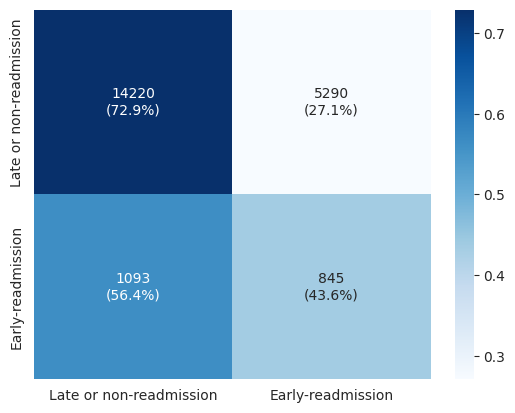

In [52]:
# Visualize confusion matrix with both absolute and percentage values
cm_smote = confusion_matrix(y_test, y_test_pred_smote)
cm_smote_norm = confusion_matrix(y_test, y_test_pred_smote, normalize='true')

annotations_smote = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smote, cm_smote_norm)
])

sns.heatmap(
    cm_smote_norm,
    annot=annotations_smote,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **5. Optuna Hyper-parameter Tuning | SMOTE + Tomek Links**
Hyper-parameter tuning of the model using Optuna, by oversampling with SMOTE and undersampling with Tomek Links.

### 5.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [53]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter suggestions
    hidden_layers = [trial.suggest_int(f"n_units_l{i}", 16, 128, step=8) for i in range(trial.suggest_int("n_layers", 1, 3))]
    dropouts = [trial.suggest_float(f"dropout_l{i}", 0.0, 0.5, step=0.05) for i in range(len(hidden_layers))]
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    optimizer_name = trial.suggest_categorical("optimizer", ['adam', 'sgd', 'rmsprop'])
    
    # Creating the activation function
    activation_name = trial.suggest_categorical("activation", ['relu', 'selu', 'tanh', 'sigmoid'])
    activation_dict = {
        'relu': nn.ReLU,
        'selu': nn.SELU,
        'tanh': nn.Tanh,
        'sigmoid': nn.Sigmoid
    }
    activation_fn = activation_dict[activation_name]()
    
    # Loading the optimizer
    optimizer_dict = {
        'adam': torch.optim.Adam,
        'sgd': torch.optim.SGD,
        'rmsprop': torch.optim.RMSprop
    }
    optimizer_fn = optimizer_dict[optimizer_name]
    
    # Sampling strategy
    sampler = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE)
    
    # Stratified K-Fold setup
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        # Get the current fold
        X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        # Apply Random Under-Sampling
        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_fold, y_train_fold)
        
        # Convert dataset to tensors
        X_train_tensor = torch.tensor(X_train_resampled.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val_fold.values, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val_fold.values, dtype=torch.long)
        
        # Create dataloaders for the current fold
        train_loader = DataLoader(DiabeticDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(DiabeticDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
        
        # Create a new model instance for each fold
        model = NN(
            input_size=X_train.shape[1],
            hidden_layers=hidden_layers,
            activation_fn=activation_fn,
            dropouts=dropouts,
            output_size=NUM_CLASSES
        ).to(DEVICE)
        
        # Compile the model
        optimizer = optimizer_fn(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
        model.compile(optimizer, criterion)

        # Train and validate the model
        f1, _ = model.fit(
            train_loader,
            val_loader,
            DEVICE,
            patience=PATIENCE,
            max_epochs=EPOCHS
        )
        scores.append(f1)

    # Return the average F1-Macro score across all folds
    f1_mean = sum(scores) / len(scores)
    print("Cross validation scores: {}".format(list(map(lambda x: round(float(x), 6), scores))))
    print("Average score: {}".format(f1_mean))
    
    return f1_mean

In [54]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE_TOMEK))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-23 07:48:57,239] Using an existing study with name 'Diabetes_130-US' instead of creating a new one.


### 5.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [13]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=1 # GPU can only support one job per time
)

 17%|█▋        | 34/200 [00:54<04:26,  1.61s/it]
[I 2025-01-23 00:15:51,285] Trial 0 finished with value: 0.5316178580584789 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 128, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.30000000000000004, 'lr': 0.0026536590823549467, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 0 with value: 0.5316178580584789.


Cross validation scores: [0.529824, 0.530582, 0.537921, 0.531001, 0.528761]
Average score: 0.5316178580584789


  8%|▊         | 17/200 [00:29<05:18,  1.74s/it]
[I 2025-01-23 00:20:31,012] Trial 1 finished with value: 0.5369036938883587 and parameters: {'n_layers': 3, 'n_units_l0': 72, 'n_units_l1': 112, 'n_units_l2': 128, 'dropout_l0': 0.45, 'dropout_l1': 0.15000000000000002, 'dropout_l2': 0.30000000000000004, 'lr': 0.004156363540430432, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 1 with value: 0.5369036938883587.


Cross validation scores: [0.535413, 0.542922, 0.551327, 0.530695, 0.524161]
Average score: 0.5369036938883587


 10%|█         | 21/200 [00:27<03:55,  1.32s/it]
[I 2025-01-23 00:23:04,330] Trial 2 finished with value: 0.5174006911922688 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 16, 'dropout_l0': 0.1, 'dropout_l1': 0.2, 'lr': 0.0024751269602064094, 'batch_size': 32, 'optimizer': 'sgd', 'activation': 'selu'}. Best is trial 1 with value: 0.5369036938883587.


Cross validation scores: [0.513872, 0.52163, 0.529853, 0.508999, 0.51265]
Average score: 0.5174006911922688


  8%|▊         | 15/200 [00:09<01:51,  1.65it/s]
[I 2025-01-23 00:24:24,542] Trial 3 finished with value: 0.5342253884185353 and parameters: {'n_layers': 2, 'n_units_l0': 56, 'n_units_l1': 40, 'dropout_l0': 0.2, 'dropout_l1': 0.30000000000000004, 'lr': 0.0002078883867918235, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 1 with value: 0.5369036938883587.


Cross validation scores: [0.521416, 0.540853, 0.522649, 0.539176, 0.547032]
Average score: 0.5342253884185353


  8%|▊         | 16/200 [00:22<04:19,  1.41s/it]
[I 2025-01-23 00:26:45,332] Trial 4 finished with value: 0.5214936319412342 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 16, 'dropout_l0': 0.25, 'dropout_l1': 0.25, 'lr': 0.0036906476729552783, 'batch_size': 32, 'optimizer': 'sgd', 'activation': 'selu'}. Best is trial 1 with value: 0.5369036938883587.


Cross validation scores: [0.516442, 0.531922, 0.524323, 0.519477, 0.515304]
Average score: 0.5214936319412342


  8%|▊         | 15/200 [00:24<05:01,  1.63s/it]
[I 2025-01-23 00:29:20,361] Trial 5 finished with value: 0.5236727680929049 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 56, 'dropout_l0': 0.45, 'dropout_l1': 0.45, 'lr': 7.750283070716948e-05, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 1 with value: 0.5369036938883587.


Cross validation scores: [0.519891, 0.524416, 0.537266, 0.519342, 0.517449]
Average score: 0.5236727680929049


 11%|█         | 22/200 [00:10<01:27,  2.03it/s]
[I 2025-01-23 00:30:49,091] Trial 6 finished with value: 0.5481036271421073 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 88, 'dropout_l0': 0.15000000000000002, 'dropout_l1': 0.05, 'lr': 0.09905695041134392, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.545329, 0.548792, 0.55118, 0.549383, 0.545834]
Average score: 0.5481036271421073


 27%|██▋       | 54/200 [00:47<02:08,  1.13it/s]
[I 2025-01-23 00:33:36,994] Trial 7 finished with value: 0.5347848993329206 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 104, 'dropout_l0': 0.4, 'dropout_l1': 0.45, 'lr': 0.012590518424726376, 'batch_size': 64, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.526551, 0.543764, 0.537558, 0.543883, 0.522169]
Average score: 0.5347848993329206


 16%|█▌        | 32/200 [01:36<08:27,  3.02s/it]
[I 2025-01-23 00:40:35,181] Trial 8 finished with value: 0.5394041223121123 and parameters: {'n_layers': 3, 'n_units_l0': 96, 'n_units_l1': 96, 'n_units_l2': 72, 'dropout_l0': 0.2, 'dropout_l1': 0.5, 'dropout_l2': 0.30000000000000004, 'lr': 0.001375981904050833, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.54672, 0.53934, 0.542377, 0.523162, 0.54542]
Average score: 0.5394041223121123


 12%|█▏        | 24/200 [00:13<01:42,  1.72it/s]
[I 2025-01-23 00:42:00,887] Trial 9 finished with value: 0.5320169103206798 and parameters: {'n_layers': 3, 'n_units_l0': 48, 'n_units_l1': 120, 'n_units_l2': 96, 'dropout_l0': 0.1, 'dropout_l1': 0.4, 'dropout_l2': 0.1, 'lr': 0.028222548122153395, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.476352, 0.554879, 0.555345, 0.531664, 0.541844]
Average score: 0.5320169103206798


  8%|▊         | 15/200 [00:06<01:20,  2.29it/s]
[I 2025-01-23 00:43:04,813] Trial 10 finished with value: 0.5390052957924689 and parameters: {'n_layers': 1, 'n_units_l0': 16, 'dropout_l0': 0.0, 'lr': 0.08419051856633127, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.538128, 0.540882, 0.547658, 0.526963, 0.541396]
Average score: 0.5390052957924689


 10%|█         | 20/200 [00:52<07:48,  2.61s/it]
[I 2025-01-23 00:48:42,730] Trial 11 finished with value: 0.5206937802981706 and parameters: {'n_layers': 3, 'n_units_l0': 88, 'n_units_l1': 88, 'n_units_l2': 24, 'dropout_l0': 0.25, 'dropout_l1': 0.0, 'dropout_l2': 0.5, 'lr': 0.0003670007509054511, 'batch_size': 16, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.51986, 0.520823, 0.521138, 0.523086, 0.518561]
Average score: 0.5206937802981706


  8%|▊         | 17/200 [00:39<07:04,  2.32s/it]
[I 2025-01-23 00:52:26,329] Trial 12 finished with value: 0.5185758430634306 and parameters: {'n_layers': 1, 'n_units_l0': 128, 'dropout_l0': 0.15000000000000002, 'lr': 1.0613565497819229e-05, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.517935, 0.518042, 0.525766, 0.518953, 0.512183]
Average score: 0.5185758430634306


  8%|▊         | 17/200 [00:44<07:55,  2.60s/it]
[I 2025-01-23 00:58:45,980] Trial 13 finished with value: 0.5302922659634932 and parameters: {'n_layers': 3, 'n_units_l0': 96, 'n_units_l1': 80, 'n_units_l2': 56, 'dropout_l0': 0.30000000000000004, 'dropout_l1': 0.0, 'dropout_l2': 0.30000000000000004, 'lr': 0.07335041617380139, 'batch_size': 16, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.52586, 0.536167, 0.531102, 0.5296, 0.528732]
Average score: 0.5302922659634932


 16%|█▋        | 33/200 [00:24<02:03,  1.35it/s]
[I 2025-01-23 01:01:20,911] Trial 14 finished with value: 0.5140589074210299 and parameters: {'n_layers': 1, 'n_units_l0': 40, 'dropout_l0': 0.0, 'lr': 3.3469100384438345e-05, 'batch_size': 64, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.514913, 0.515357, 0.521287, 0.510361, 0.508377]
Average score: 0.5140589074210299


  9%|▉         | 18/200 [00:55<09:24,  3.10s/it]
[I 2025-01-23 01:07:29,182] Trial 15 finished with value: 0.5251504491664349 and parameters: {'n_layers': 3, 'n_units_l0': 80, 'n_units_l1': 88, 'n_units_l2': 72, 'dropout_l0': 0.15000000000000002, 'dropout_l1': 0.15000000000000002, 'dropout_l2': 0.5, 'lr': 0.0006889250655196833, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.527651, 0.514196, 0.526752, 0.54146, 0.515693]
Average score: 0.5251504491664349


  9%|▉         | 18/200 [00:09<01:38,  1.86it/s]
[I 2025-01-23 01:08:44,302] Trial 16 finished with value: 0.5190962825371157 and parameters: {'n_layers': 3, 'n_units_l0': 104, 'n_units_l1': 64, 'n_units_l2': 16, 'dropout_l0': 0.1, 'dropout_l1': 0.1, 'dropout_l2': 0.0, 'lr': 0.013634042208063158, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.517844, 0.521243, 0.524646, 0.5167, 0.515049]
Average score: 0.5190962825371157


  8%|▊         | 16/200 [00:29<05:41,  1.86s/it]
[I 2025-01-23 01:11:58,924] Trial 17 finished with value: 0.54263391910823 and parameters: {'n_layers': 1, 'n_units_l0': 128, 'dropout_l0': 0.2, 'lr': 0.001036797445777333, 'batch_size': 16, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.548327, 0.542689, 0.542849, 0.534512, 0.544791]
Average score: 0.54263391910823


 11%|█         | 22/200 [00:09<01:17,  2.30it/s]
[I 2025-01-23 01:14:47,764] Trial 18 finished with value: 0.4657648794750425 and parameters: {'n_layers': 1, 'n_units_l0': 32, 'dropout_l0': 0.30000000000000004, 'lr': 0.00013493314591735475, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.360396, 0.540755, 0.494486, 0.444822, 0.488366]
Average score: 0.4657648794750425


  8%|▊         | 15/200 [00:09<02:02,  1.51it/s]
[I 2025-01-23 01:16:10,988] Trial 19 finished with value: 0.5406999873394671 and parameters: {'n_layers': 1, 'n_units_l0': 128, 'dropout_l0': 0.05, 'lr': 0.010041372256066812, 'batch_size': 64, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.540658, 0.548104, 0.549792, 0.529582, 0.535363]
Average score: 0.5406999873394671


 10%|█         | 20/200 [00:37<05:34,  1.86s/it]
[I 2025-01-23 01:20:02,804] Trial 20 finished with value: 0.5460659847103624 and parameters: {'n_layers': 1, 'n_units_l0': 120, 'dropout_l0': 0.2, 'lr': 0.04010204872042254, 'batch_size': 16, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.542989, 0.548879, 0.556241, 0.544426, 0.537795]
Average score: 0.5460659847103624


  9%|▉         | 18/200 [00:33<05:41,  1.87s/it]
[I 2025-01-23 01:24:03,587] Trial 21 finished with value: 0.5438330050038215 and parameters: {'n_layers': 1, 'n_units_l0': 120, 'dropout_l0': 0.2, 'lr': 0.03778265944414402, 'batch_size': 16, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.53555, 0.544293, 0.552351, 0.547355, 0.539616]
Average score: 0.5438330050038215


  9%|▉         | 18/200 [00:33<05:41,  1.88s/it]
[I 2025-01-23 01:27:53,322] Trial 22 finished with value: 0.5453596442597393 and parameters: {'n_layers': 1, 'n_units_l0': 112, 'dropout_l0': 0.15000000000000002, 'lr': 0.035598682863932495, 'batch_size': 16, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.545218, 0.549685, 0.554446, 0.544511, 0.532938]
Average score: 0.5453596442597393


 14%|█▍        | 29/200 [00:53<05:15,  1.85s/it]
[I 2025-01-23 01:31:51,586] Trial 23 finished with value: 0.5432546123894253 and parameters: {'n_layers': 1, 'n_units_l0': 112, 'dropout_l0': 0.05, 'lr': 0.032504618892405364, 'batch_size': 16, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.541806, 0.55529, 0.53506, 0.546682, 0.537436]
Average score: 0.5432546123894253


 13%|█▎        | 26/200 [00:12<01:25,  2.04it/s]
[I 2025-01-23 01:33:22,074] Trial 24 finished with value: 0.5439506842452749 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 48, 'dropout_l0': 0.15000000000000002, 'dropout_l1': 0.05, 'lr': 0.08317923156828697, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.545366, 0.543561, 0.552068, 0.5362, 0.542558]
Average score: 0.5439506842452749


  9%|▉         | 18/200 [00:34<05:50,  1.93s/it]
[I 2025-01-23 01:36:35,673] Trial 25 finished with value: 0.5300967473042072 and parameters: {'n_layers': 1, 'n_units_l0': 104, 'dropout_l0': 0.30000000000000004, 'lr': 0.007896202660149865, 'batch_size': 16, 'optimizer': 'sgd', 'activation': 'selu'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.53394, 0.53418, 0.531657, 0.534755, 0.515952]
Average score: 0.5300967473042072


  8%|▊         | 15/200 [00:36<07:30,  2.43s/it]
[I 2025-01-23 01:42:03,352] Trial 26 finished with value: 0.5263147634951333 and parameters: {'n_layers': 1, 'n_units_l0': 120, 'dropout_l0': 0.15000000000000002, 'lr': 0.02199213500882427, 'batch_size': 16, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.530428, 0.528897, 0.529906, 0.524637, 0.517706]
Average score: 0.5263147634951333


 18%|█▊        | 35/200 [00:16<01:18,  2.09it/s]
[I 2025-01-23 01:43:44,429] Trial 27 finished with value: 0.5479108885392213 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 72, 'dropout_l0': 0.25, 'dropout_l1': 0.1, 'lr': 0.04794987477785572, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.550335, 0.544896, 0.556615, 0.543394, 0.544314]
Average score: 0.5479108885392213


 16%|█▋        | 33/200 [00:15<01:20,  2.07it/s]
[I 2025-01-23 01:45:18,888] Trial 28 finished with value: 0.5440226499587779 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 72, 'dropout_l0': 0.25, 'dropout_l1': 0.1, 'lr': 0.048552846479786665, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.546678, 0.543144, 0.549656, 0.542305, 0.53833]
Average score: 0.5440226499587779


  8%|▊         | 15/200 [00:07<01:32,  2.01it/s]
[I 2025-01-23 01:46:38,012] Trial 29 finished with value: 0.5143880294749004 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 40, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.05, 'lr': 0.0055421607694361, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.546407, 0.557042, 0.483494, 0.476325, 0.508671]
Average score: 0.5143880294749004


 22%|██▏       | 44/200 [00:24<01:25,  1.83it/s]
[I 2025-01-23 01:48:29,798] Trial 30 finished with value: 0.5475162966901459 and parameters: {'n_layers': 2, 'n_units_l0': 72, 'n_units_l1': 72, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.15000000000000002, 'lr': 0.02182409395040784, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'selu'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.548947, 0.553517, 0.550389, 0.542512, 0.542216]
Average score: 0.5475162966901459


 12%|█▏        | 24/200 [00:13<01:36,  1.82it/s]
[I 2025-01-23 01:50:04,943] Trial 31 finished with value: 0.5440761342677685 and parameters: {'n_layers': 2, 'n_units_l0': 72, 'n_units_l1': 72, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.15000000000000002, 'lr': 0.016704542193084617, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'selu'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.549124, 0.547595, 0.55469, 0.535966, 0.533006]
Average score: 0.5440761342677685


  8%|▊         | 16/200 [00:08<01:43,  1.78it/s]
[I 2025-01-23 01:51:26,019] Trial 32 finished with value: 0.5302223504539928 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 80, 'dropout_l0': 0.4, 'dropout_l1': 0.1, 'lr': 0.05556730778626605, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'selu'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.513365, 0.536117, 0.533839, 0.534569, 0.533221]
Average score: 0.5302223504539928


 10%|▉         | 19/200 [00:10<01:40,  1.80it/s]
[I 2025-01-23 01:52:40,963] Trial 33 finished with value: 0.47633597337075617 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 64, 'dropout_l0': 0.5, 'dropout_l1': 0.2, 'lr': 0.09962097339849738, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'selu'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


 16%|█▋        | 33/200 [00:17<01:29,  1.87it/s]
[I 2025-01-23 01:54:14,314] Trial 34 finished with value: 0.5306756336261882 and parameters: {'n_layers': 2, 'n_units_l0': 56, 'n_units_l1': 96, 'dropout_l0': 0.30000000000000004, 'dropout_l1': 0.05, 'lr': 0.02014218734032017, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.518631, 0.53152, 0.54731, 0.521586, 0.534332]
Average score: 0.5306756336261882


  8%|▊         | 16/200 [00:25<04:55,  1.61s/it]
[I 2025-01-23 01:57:44,364] Trial 35 finished with value: 0.5332373731026011 and parameters: {'n_layers': 2, 'n_units_l0': 72, 'n_units_l1': 56, 'dropout_l0': 0.4, 'dropout_l1': 0.2, 'lr': 0.0023326536958710167, 'batch_size': 32, 'optimizer': 'adam', 'activation': 'selu'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.528927, 0.549289, 0.546464, 0.516337, 0.525169]
Average score: 0.5332373731026011


  8%|▊         | 15/200 [00:07<01:30,  2.04it/s]
[I 2025-01-23 01:59:05,343] Trial 36 finished with value: 0.5232826824574695 and parameters: {'n_layers': 2, 'n_units_l0': 56, 'n_units_l1': 80, 'dropout_l0': 0.25, 'dropout_l1': 0.0, 'lr': 0.006642656210166883, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'selu'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.516296, 0.525632, 0.524112, 0.525272, 0.525102]
Average score: 0.5232826824574695


  8%|▊         | 15/200 [00:20<04:08,  1.34s/it]
[I 2025-01-23 02:01:37,576] Trial 37 finished with value: 0.5195306463425922 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 104, 'dropout_l0': 0.2, 'dropout_l1': 0.1, 'lr': 0.04195496692869185, 'batch_size': 32, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.524751, 0.519553, 0.521452, 0.516589, 0.515308]
Average score: 0.5195306463425922


 11%|█         | 22/200 [00:19<02:36,  1.14it/s]
[I 2025-01-23 02:03:53,025] Trial 38 finished with value: 0.5240794160675575 and parameters: {'n_layers': 2, 'n_units_l0': 72, 'n_units_l1': 64, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.25, 'lr': 0.0034313457707599443, 'batch_size': 64, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.522434, 0.524482, 0.536165, 0.523624, 0.513692]
Average score: 0.5240794160675575


 10%|▉         | 19/200 [00:09<01:30,  2.01it/s]
[I 2025-01-23 02:05:05,556] Trial 39 finished with value: 0.5255912868822963 and parameters: {'n_layers': 2, 'n_units_l0': 104, 'n_units_l1': 32, 'dropout_l0': 0.2, 'dropout_l1': 0.05, 'lr': 0.05176156276848995, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'selu'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.527909, 0.537381, 0.530841, 0.517507, 0.514319]
Average score: 0.5255912868822963


 10%|█         | 20/200 [00:10<01:37,  1.85it/s]
[I 2025-01-23 02:06:43,526] Trial 40 finished with value: 0.5474679115486174 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 88, 'dropout_l0': 0.45, 'dropout_l1': 0.15000000000000002, 'lr': 0.026593651013302737, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 6 with value: 0.5481036271421073.


Cross validation scores: [0.550183, 0.544539, 0.55409, 0.545828, 0.542699]
Average score: 0.5474679115486174


 11%|█         | 22/200 [00:11<01:37,  1.83it/s]
[I 2025-01-23 02:08:31,610] Trial 41 finished with value: 0.5485024274655534 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 88, 'dropout_l0': 0.45, 'dropout_l1': 0.15000000000000002, 'lr': 0.02526317551949183, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.538854, 0.552348, 0.555061, 0.550579, 0.54567]
Average score: 0.5485024274655534


  8%|▊         | 17/200 [00:09<01:37,  1.88it/s]
[I 2025-01-23 02:10:01,764] Trial 42 finished with value: 0.5458714112735199 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 88, 'dropout_l0': 0.45, 'dropout_l1': 0.15000000000000002, 'lr': 0.02299851623460926, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.541948, 0.554822, 0.553265, 0.541963, 0.537359]
Average score: 0.5458714112735199


  8%|▊         | 15/200 [00:08<01:40,  1.83it/s]
[I 2025-01-23 02:11:44,314] Trial 43 finished with value: 0.5481565999102528 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 96, 'dropout_l0': 0.5, 'dropout_l1': 0.1, 'lr': 0.013688418148407523, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.548895, 0.546327, 0.557222, 0.542306, 0.546033]
Average score: 0.5481565999102528


  8%|▊         | 17/200 [00:09<01:42,  1.78it/s]
[I 2025-01-23 02:13:20,980] Trial 44 finished with value: 0.5447003835419812 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 96, 'dropout_l0': 0.5, 'dropout_l1': 0.1, 'lr': 0.01173174559557803, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.543204, 0.54733, 0.553192, 0.534226, 0.545551]
Average score: 0.5447003835419812


  8%|▊         | 15/200 [00:08<01:41,  1.82it/s]
[I 2025-01-23 02:14:32,858] Trial 45 finished with value: 0.4815449678862295 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 128, 'dropout_l0': 0.5, 'dropout_l1': 0.05, 'lr': 0.06547603484837136, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.50237]
Average score: 0.4815449678862295


 13%|█▎        | 26/200 [00:14<01:35,  1.83it/s]
[I 2025-01-23 02:15:58,442] Trial 46 finished with value: 0.5411835511858643 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 112, 'dropout_l0': 0.4, 'dropout_l1': 0.2, 'lr': 0.017308410653113396, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.525579, 0.542163, 0.548895, 0.547581, 0.5417]
Average score: 0.5411835511858643


 16%|█▌        | 31/200 [00:16<01:28,  1.92it/s]
[I 2025-01-23 02:17:22,651] Trial 47 finished with value: 0.5269689039684732 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 80, 'dropout_l0': 0.45, 'dropout_l1': 0.15000000000000002, 'lr': 0.0016745855322393732, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.536005, 0.520662, 0.548956, 0.518034, 0.511188]
Average score: 0.5269689039684732


 12%|█▏        | 23/200 [00:12<01:35,  1.85it/s]
[I 2025-01-23 02:18:45,416] Trial 48 finished with value: 0.5442370360089719 and parameters: {'n_layers': 2, 'n_units_l0': 72, 'n_units_l1': 104, 'dropout_l0': 0.45, 'dropout_l1': 0.1, 'lr': 0.008686505971273992, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.547766, 0.545021, 0.55489, 0.537603, 0.535905]
Average score: 0.5442370360089719


 28%|██▊       | 55/200 [01:32<04:02,  1.67s/it]
[I 2025-01-23 02:23:23,816] Trial 49 finished with value: 0.5333175064850803 and parameters: {'n_layers': 3, 'n_units_l0': 56, 'n_units_l1': 72, 'n_units_l2': 128, 'dropout_l0': 0.5, 'dropout_l1': 0.30000000000000004, 'dropout_l2': 0.1, 'lr': 0.004217988235373032, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.532363, 0.537482, 0.528767, 0.528837, 0.539139]
Average score: 0.5333175064850803


 10%|▉         | 19/200 [00:10<01:36,  1.87it/s]
[I 2025-01-23 02:24:50,229] Trial 50 finished with value: 0.5177336625936085 and parameters: {'n_layers': 2, 'n_units_l0': 72, 'n_units_l1': 96, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.2, 'lr': 0.0006222455993844202, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.516492, 0.518458, 0.524267, 0.520519, 0.508932]
Average score: 0.5177336625936085


 14%|█▎        | 27/200 [00:14<01:32,  1.87it/s]
[I 2025-01-23 02:26:24,655] Trial 51 finished with value: 0.5463613040508416 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 88, 'dropout_l0': 0.45, 'dropout_l1': 0.15000000000000002, 'lr': 0.02722271151044837, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.544847, 0.551436, 0.553349, 0.546064, 0.53611]
Average score: 0.5463613040508416


  8%|▊         | 15/200 [00:08<01:42,  1.80it/s]
[I 2025-01-23 02:27:54,645] Trial 52 finished with value: 0.5336343031587452 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 80, 'dropout_l0': 0.45, 'dropout_l1': 0.1, 'lr': 0.06466409176508778, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.476352, 0.553027, 0.555623, 0.55238, 0.53079]
Average score: 0.5336343031587452


  8%|▊         | 16/200 [00:08<01:39,  1.84it/s]
[I 2025-01-23 02:29:05,821] Trial 53 finished with value: 0.48571392369483146 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 88, 'dropout_l0': 0.4, 'dropout_l1': 0.25, 'lr': 0.09970072659293609, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.523242, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.48571392369483146


 18%|█▊        | 37/200 [00:30<02:13,  1.22it/s]
[I 2025-01-23 02:31:28,977] Trial 54 finished with value: 0.5471657062316766 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 112, 'dropout_l0': 0.5, 'dropout_l1': 0.15000000000000002, 'lr': 0.013117637925008042, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.547701, 0.556629, 0.5447, 0.549199, 0.5376]
Average score: 0.5471657062316766


 12%|█▏        | 24/200 [00:13<01:35,  1.84it/s]
[I 2025-01-23 02:33:05,612] Trial 55 finished with value: 0.546573372993216 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 104, 'dropout_l0': 0.4, 'dropout_l1': 0.35000000000000003, 'lr': 0.027137305788830446, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.546055, 0.553904, 0.552244, 0.530649, 0.550015]
Average score: 0.546573372993216


 17%|█▋        | 34/200 [00:18<01:28,  1.87it/s]
[I 2025-01-23 02:34:35,103] Trial 56 finished with value: 0.54469673856915 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 72, 'dropout_l0': 0.05, 'dropout_l1': 0.05, 'lr': 0.0161234443590758, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.546787, 0.545578, 0.552419, 0.538572, 0.540127]
Average score: 0.54469673856915


 10%|█         | 21/200 [00:12<01:49,  1.64it/s]
[I 2025-01-23 02:35:56,288] Trial 57 finished with value: 0.48238219260298437 and parameters: {'n_layers': 3, 'n_units_l0': 80, 'n_units_l1': 96, 'n_units_l2': 40, 'dropout_l0': 0.45, 'dropout_l1': 0.2, 'dropout_l2': 0.4, 'lr': 0.030551582473068373, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'selu'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.476352, 0.476352, 0.506556, 0.476325, 0.476325]
Average score: 0.48238219260298437


  8%|▊         | 15/200 [00:08<01:38,  1.87it/s]
[I 2025-01-23 02:37:06,075] Trial 58 finished with value: 0.5227441844058862 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 88, 'dropout_l0': 0.25, 'dropout_l1': 0.0, 'lr': 4.318175179114408e-05, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.514432, 0.527415, 0.525432, 0.527621, 0.51882]
Average score: 0.5227441844058862


  8%|▊         | 16/200 [00:08<01:40,  1.82it/s]
[I 2025-01-23 02:38:15,574] Trial 59 finished with value: 0.47633597337075617 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 72, 'dropout_l0': 0.1, 'dropout_l1': 0.15000000000000002, 'lr': 0.06626388548903088, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


 12%|█▏        | 24/200 [00:21<02:39,  1.10it/s]
[I 2025-01-23 02:40:58,043] Trial 60 finished with value: 0.5401514155212566 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 56, 'dropout_l0': 0.30000000000000004, 'dropout_l1': 0.1, 'lr': 0.04267345465868992, 'batch_size': 64, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.526726, 0.560927, 0.538538, 0.550126, 0.52444]
Average score: 0.5401514155212566


 16%|█▌        | 32/200 [00:26<02:19,  1.21it/s]
[I 2025-01-23 02:43:45,714] Trial 61 finished with value: 0.5421469352994872 and parameters: {'n_layers': 2, 'n_units_l0': 104, 'n_units_l1': 120, 'dropout_l0': 0.5, 'dropout_l1': 0.15000000000000002, 'lr': 0.012685013975333255, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.542881, 0.546911, 0.544197, 0.531159, 0.545587]
Average score: 0.5421469352994872


 15%|█▌        | 30/200 [00:25<02:21,  1.20it/s]
[I 2025-01-23 02:46:00,886] Trial 62 finished with value: 0.5421162410473626 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 112, 'dropout_l0': 0.5, 'dropout_l1': 0.15000000000000002, 'lr': 0.005977044498613061, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.545548, 0.550522, 0.535713, 0.533954, 0.544844]
Average score: 0.5421162410473626


  8%|▊         | 15/200 [00:13<02:41,  1.14it/s]
[I 2025-01-23 02:48:05,372] Trial 63 finished with value: 0.5420699128142077 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 120, 'dropout_l0': 0.5, 'dropout_l1': 0.1, 'lr': 0.011806841034168056, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.540096, 0.550742, 0.546667, 0.535395, 0.53745]
Average score: 0.5420699128142077


  8%|▊         | 15/200 [00:13<02:43,  1.13it/s]
[I 2025-01-23 02:50:40,681] Trial 64 finished with value: 0.5452052902239216 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 80, 'dropout_l0': 0.45, 'dropout_l1': 0.2, 'lr': 0.02393185739177048, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.548271, 0.551521, 0.5491, 0.546457, 0.530678]
Average score: 0.5452052902239216


  9%|▉         | 18/200 [00:23<03:58,  1.31s/it]
[I 2025-01-23 02:53:52,616] Trial 65 finished with value: 0.544881072113229 and parameters: {'n_layers': 2, 'n_units_l0': 16, 'n_units_l1': 104, 'dropout_l0': 0.5, 'dropout_l1': 0.05, 'lr': 0.03858344923221595, 'batch_size': 32, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.543301, 0.544124, 0.553199, 0.542598, 0.541184]
Average score: 0.544881072113229


 10%|█         | 21/200 [00:11<01:36,  1.86it/s]
[I 2025-01-23 02:55:22,192] Trial 66 finished with value: 0.5460588626208918 and parameters: {'n_layers': 2, 'n_units_l0': 72, 'n_units_l1': 64, 'dropout_l0': 0.45, 'dropout_l1': 0.1, 'lr': 0.00916809309351115, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.541716, 0.555223, 0.540764, 0.552991, 0.539601]
Average score: 0.5460588626208918


 15%|█▌        | 30/200 [00:22<02:06,  1.34it/s]
[I 2025-01-23 02:57:54,725] Trial 67 finished with value: 0.5324753867005575 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 88, 'dropout_l0': 0.4, 'dropout_l1': 0.15000000000000002, 'lr': 0.018625626118141184, 'batch_size': 64, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.548602, 0.476352, 0.553443, 0.546272, 0.537707]
Average score: 0.5324753867005575


  8%|▊         | 15/200 [00:08<01:47,  1.73it/s]
[I 2025-01-23 02:59:09,140] Trial 68 finished with value: 0.5228499926377514 and parameters: {'n_layers': 2, 'n_units_l0': 104, 'n_units_l1': 96, 'dropout_l0': 0.30000000000000004, 'dropout_l1': 0.05, 'lr': 0.0002679565121105727, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'selu'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.518213, 0.525763, 0.531119, 0.52268, 0.516475]
Average score: 0.5228499926377514


  8%|▊         | 15/200 [00:07<01:31,  2.02it/s]
[I 2025-01-23 03:00:54,345] Trial 69 finished with value: 0.5182678699852479 and parameters: {'n_layers': 2, 'n_units_l0': 72, 'n_units_l1': 112, 'dropout_l0': 0.45, 'dropout_l1': 0.15000000000000002, 'lr': 0.07456834680510133, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.543066, 0.546626, 0.476325, 0.548997, 0.476325]
Average score: 0.5182678699852479


 10%|▉         | 19/200 [00:10<01:35,  1.89it/s]
[I 2025-01-23 03:02:16,261] Trial 70 finished with value: 0.5379673648104951 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 80, 'dropout_l0': 0.5, 'dropout_l1': 0.0, 'lr': 0.031520148443866254, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'tanh'}. Best is trial 41 with value: 0.5485024274655534.


Cross validation scores: [0.538166, 0.542221, 0.541083, 0.538921, 0.529445]
Average score: 0.5379673648104951


 11%|█         | 22/200 [00:11<01:36,  1.84it/s]
[I 2025-01-23 03:03:47,574] Trial 71 finished with value: 0.5497118678265022 and parameters: {'n_layers': 2, 'n_units_l0': 48, 'n_units_l1': 104, 'dropout_l0': 0.4, 'dropout_l1': 0.4, 'lr': 0.025686348216832865, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 71 with value: 0.5497118678265022.


Cross validation scores: [0.543365, 0.551293, 0.55944, 0.55332, 0.54114]
Average score: 0.5497118678265022


  8%|▊         | 15/200 [00:08<01:42,  1.80it/s]
[I 2025-01-23 03:05:31,038] Trial 72 finished with value: 0.5431612838759059 and parameters: {'n_layers': 2, 'n_units_l0': 40, 'n_units_l1': 104, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.45, 'lr': 0.015224168087320838, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 71 with value: 0.5497118678265022.


Cross validation scores: [0.546453, 0.559119, 0.553846, 0.53254, 0.523849]
Average score: 0.5431612838759059


 13%|█▎        | 26/200 [00:13<01:32,  1.88it/s]
[I 2025-01-23 03:06:53,767] Trial 73 finished with value: 0.5461741148836939 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 96, 'dropout_l0': 0.4, 'dropout_l1': 0.5, 'lr': 0.021691304909182814, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 71 with value: 0.5497118678265022.


Cross validation scores: [0.549309, 0.557676, 0.554673, 0.538538, 0.530675]
Average score: 0.5461741148836939


  8%|▊         | 15/200 [00:08<01:41,  1.82it/s]
[I 2025-01-23 03:08:13,455] Trial 74 finished with value: 0.48339134396575006 and parameters: {'n_layers': 2, 'n_units_l0': 48, 'n_units_l1': 112, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.4, 'lr': 0.05594681151806382, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 71 with value: 0.5497118678265022.


Cross validation scores: [0.476352, 0.476352, 0.511602, 0.476325, 0.476325]
Average score: 0.48339134396575006


 14%|█▍        | 29/200 [00:14<01:24,  2.02it/s]
[I 2025-01-23 03:09:36,237] Trial 75 finished with value: 0.5229066319954334 and parameters: {'n_layers': 2, 'n_units_l0': 32, 'n_units_l1': 80, 'dropout_l0': 0.4, 'dropout_l1': 0.25, 'lr': 0.04458340920720018, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'selu'}. Best is trial 71 with value: 0.5497118678265022.


Cross validation scores: [0.517335, 0.535434, 0.527314, 0.518692, 0.515759]
Average score: 0.5229066319954334


 22%|██▏       | 43/200 [00:23<01:24,  1.86it/s]
[I 2025-01-23 03:11:19,394] Trial 76 finished with value: 0.546837439613434 and parameters: {'n_layers': 2, 'n_units_l0': 48, 'n_units_l1': 64, 'dropout_l0': 0.45, 'dropout_l1': 0.30000000000000004, 'lr': 0.007570089507888785, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 71 with value: 0.5497118678265022.


Cross validation scores: [0.542505, 0.547959, 0.551512, 0.551442, 0.54077]
Average score: 0.546837439613434


 18%|█▊        | 35/200 [00:30<02:25,  1.13it/s]
[I 2025-01-23 03:13:29,134] Trial 77 finished with value: 0.5237327439964986 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 120, 'dropout_l0': 0.1, 'dropout_l1': 0.1, 'lr': 0.0046118655592829955, 'batch_size': 64, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 71 with value: 0.5497118678265022.


Cross validation scores: [0.524863, 0.53082, 0.523198, 0.516376, 0.523406]
Average score: 0.5237327439964986


  8%|▊         | 16/200 [00:24<04:41,  1.53s/it]
[I 2025-01-23 03:16:00,531] Trial 78 finished with value: 0.49381170676477437 and parameters: {'n_layers': 2, 'n_units_l0': 24, 'n_units_l1': 88, 'dropout_l0': 0.5, 'dropout_l1': 0.35000000000000003, 'lr': 0.033591933512595394, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 71 with value: 0.5497118678265022.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.494629, 0.545399]
Average score: 0.49381170676477437


  8%|▊         | 16/200 [00:08<01:32,  2.00it/s]
[I 2025-01-23 03:17:20,391] Trial 79 finished with value: 0.520670305584575 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 104, 'dropout_l0': 0.15000000000000002, 'dropout_l1': 0.15000000000000002, 'lr': 0.010812648697565054, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'selu'}. Best is trial 71 with value: 0.5497118678265022.


Cross validation scores: [0.521248, 0.526745, 0.534309, 0.511097, 0.509952]
Average score: 0.520670305584575


 12%|█▏        | 24/200 [00:12<01:35,  1.85it/s]
[I 2025-01-23 03:19:22,859] Trial 80 finished with value: 0.5530735031063096 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 56, 'dropout_l0': 0.4, 'dropout_l1': 0.2, 'lr': 0.05414647866948903, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 80 with value: 0.5530735031063096.


Cross validation scores: [0.55631, 0.554765, 0.553157, 0.551949, 0.549187]
Average score: 0.5530735031063096


  8%|▊         | 15/200 [00:08<01:40,  1.83it/s]
[I 2025-01-23 03:20:32,504] Trial 81 finished with value: 0.47633597337075617 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 56, 'dropout_l0': 0.4, 'dropout_l1': 0.2, 'lr': 0.08189012971493886, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 80 with value: 0.5530735031063096.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


  8%|▊         | 15/200 [00:08<01:42,  1.80it/s]
[I 2025-01-23 03:21:44,099] Trial 82 finished with value: 0.47633597337075617 and parameters: {'n_layers': 2, 'n_units_l0': 120, 'n_units_l1': 48, 'dropout_l0': 0.45, 'dropout_l1': 0.2, 'lr': 0.052546405061387684, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 80 with value: 0.5530735031063096.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.476325, 0.476325]
Average score: 0.47633597337075617


 11%|█         | 22/200 [00:11<01:35,  1.87it/s]
[I 2025-01-23 03:23:05,312] Trial 83 finished with value: 0.5457602717589782 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 32, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.15000000000000002, 'lr': 0.026222794559035825, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 80 with value: 0.5530735031063096.


Cross validation scores: [0.541001, 0.535879, 0.555863, 0.541271, 0.554788]
Average score: 0.5457602717589782


  8%|▊         | 15/200 [00:08<01:42,  1.81it/s]
[I 2025-01-23 03:24:23,626] Trial 84 finished with value: 0.49140391928097016 and parameters: {'n_layers': 2, 'n_units_l0': 104, 'n_units_l1': 48, 'dropout_l0': 0.4, 'dropout_l1': 0.1, 'lr': 0.05864468607638429, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 80 with value: 0.5530735031063096.


Cross validation scores: [0.476352, 0.476352, 0.476325, 0.551665, 0.476325]
Average score: 0.49140391928097016


 10%|▉         | 19/200 [00:10<01:36,  1.88it/s]
[I 2025-01-23 03:26:01,239] Trial 85 finished with value: 0.5465036472728542 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 96, 'dropout_l0': 0.45, 'dropout_l1': 0.2, 'lr': 0.020164509849793694, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}. Best is trial 80 with value: 0.5530735031063096.


Cross validation scores: [0.549407, 0.562389, 0.555994, 0.539572, 0.525156]
Average score: 0.5465036472728542


  8%|▊         | 16/200 [00:09<01:54,  1.61it/s]
[I 2025-01-23 03:27:30,510] Trial 86 finished with value: 0.5284100539510519 and parameters: {'n_layers': 3, 'n_units_l0': 72, 'n_units_l1': 72, 'n_units_l2': 104, 'dropout_l0': 0.5, 'dropout_l1': 0.15000000000000002, 'dropout_l2': 0.15000000000000002, 'lr': 0.014150445718754623, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}. Best is trial 80 with value: 0.5530735031063096.


Cross validation scores: [0.532401, 0.51854, 0.545354, 0.518626, 0.52713]
Average score: 0.5284100539510519


  8%|▊         | 15/200 [00:07<01:34,  1.96it/s]
[I 2025-01-23 03:28:36,059] Trial 87 finished with value: 0.3554381656513771 and parameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 88, 'dropout_l0': 0.25, 'dropout_l1': 0.2, 'lr': 1.1772032258606097e-05, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 80 with value: 0.5530735031063096.


Cross validation scores: [0.476352, 0.476352, 0.43637, 0.305195, 0.082921]
Average score: 0.3554381656513771


 21%|██        | 42/200 [01:51<06:59,  2.65s/it]
[I 2025-01-23 03:35:54,148] Trial 88 finished with value: 0.5563009983042818 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 96, 'dropout_l0': 0.45, 'dropout_l1': 0.25, 'lr': 0.03636975390778253, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 88 with value: 0.5563009983042818.


Cross validation scores: [0.556156, 0.56511, 0.556378, 0.556798, 0.547064]
Average score: 0.5563009983042818


 11%|█         | 22/200 [00:59<08:02,  2.71s/it]
[I 2025-01-23 03:41:00,525] Trial 89 finished with value: 0.5477080812315377 and parameters: {'n_layers': 2, 'n_units_l0': 40, 'n_units_l1': 88, 'dropout_l0': 0.4, 'dropout_l1': 0.30000000000000004, 'lr': 0.037681495581225785, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 88 with value: 0.5563009983042818.


Cross validation scores: [0.542302, 0.562477, 0.547471, 0.542811, 0.54348]
Average score: 0.5477080812315377


  8%|▊         | 17/200 [00:39<07:05,  2.33s/it]
[I 2025-01-23 03:45:36,811] Trial 90 finished with value: 0.5370894275001908 and parameters: {'n_layers': 2, 'n_units_l0': 56, 'n_units_l1': 64, 'dropout_l0': 0.35000000000000003, 'dropout_l1': 0.25, 'lr': 0.07956731325150318, 'batch_size': 16, 'optimizer': 'sgd', 'activation': 'sigmoid'}. Best is trial 88 with value: 0.5563009983042818.


Cross validation scores: [0.545461, 0.525842, 0.542815, 0.535151, 0.536178]
Average score: 0.5370894275001908


 15%|█▌        | 30/200 [01:20<07:33,  2.67s/it]
[I 2025-01-23 03:52:53,948] Trial 91 finished with value: 0.5532207652087193 and parameters: {'n_layers': 2, 'n_units_l0': 40, 'n_units_l1': 88, 'dropout_l0': 0.4, 'dropout_l1': 0.35000000000000003, 'lr': 0.035894074131195275, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 88 with value: 0.5563009983042818.


Cross validation scores: [0.55038, 0.560752, 0.556458, 0.552154, 0.54636]
Average score: 0.5532207652087193


 12%|█▏        | 24/200 [01:04<07:54,  2.70s/it]
[I 2025-01-23 04:01:15,569] Trial 92 finished with value: 0.5545624356644034 and parameters: {'n_layers': 2, 'n_units_l0': 40, 'n_units_l1': 96, 'dropout_l0': 0.4, 'dropout_l1': 0.4, 'lr': 0.03669417797464366, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 88 with value: 0.5563009983042818.


Cross validation scores: [0.553769, 0.558674, 0.559779, 0.553903, 0.546688]
Average score: 0.5545624356644034


 20%|██        | 40/200 [01:45<07:02,  2.64s/it]
[I 2025-01-23 04:07:52,595] Trial 93 finished with value: 0.5567057356418509 and parameters: {'n_layers': 2, 'n_units_l0': 40, 'n_units_l1': 96, 'dropout_l0': 0.4, 'dropout_l1': 0.4, 'lr': 0.036870573696692104, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 93 with value: 0.5567057356418509.


Cross validation scores: [0.560343, 0.560586, 0.55958, 0.557407, 0.545612]
Average score: 0.5567057356418509


 15%|█▌        | 30/200 [01:20<07:35,  2.68s/it]
[I 2025-01-23 04:15:40,229] Trial 94 finished with value: 0.5559013009029256 and parameters: {'n_layers': 2, 'n_units_l0': 40, 'n_units_l1': 96, 'dropout_l0': 0.4, 'dropout_l1': 0.45, 'lr': 0.04512026741150669, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 93 with value: 0.5567057356418509.


Cross validation scores: [0.553401, 0.566475, 0.563621, 0.549971, 0.546038]
Average score: 0.5559013009029256


 12%|█▎        | 25/200 [01:07<07:52,  2.70s/it]
[I 2025-01-23 04:22:20,191] Trial 95 finished with value: 0.5532685518558786 and parameters: {'n_layers': 2, 'n_units_l0': 32, 'n_units_l1': 96, 'dropout_l0': 0.4, 'dropout_l1': 0.4, 'lr': 0.04423521915003788, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 93 with value: 0.5567057356418509.


Cross validation scores: [0.553133, 0.559075, 0.553129, 0.558388, 0.542618]
Average score: 0.5532685518558786


  8%|▊         | 17/200 [00:46<08:19,  2.73s/it]
[I 2025-01-23 04:28:33,346] Trial 96 finished with value: 0.5557559301952333 and parameters: {'n_layers': 2, 'n_units_l0': 32, 'n_units_l1': 96, 'dropout_l0': 0.4, 'dropout_l1': 0.4, 'lr': 0.04640690288002027, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 93 with value: 0.5567057356418509.


Cross validation scores: [0.553518, 0.562243, 0.561948, 0.557, 0.54407]
Average score: 0.5557559301952333


 16%|█▋        | 33/200 [01:27<07:24,  2.66s/it]
[I 2025-01-23 04:35:38,919] Trial 97 finished with value: 0.5530372630522159 and parameters: {'n_layers': 2, 'n_units_l0': 32, 'n_units_l1': 96, 'dropout_l0': 0.4, 'dropout_l1': 0.4, 'lr': 0.04634392775190972, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 93 with value: 0.5567057356418509.


Cross validation scores: [0.548682, 0.562939, 0.552365, 0.553771, 0.54743]
Average score: 0.5530372630522159


 27%|██▋       | 54/200 [02:21<06:23,  2.62s/it]
[I 2025-01-23 04:42:18,700] Trial 98 finished with value: 0.5524911988956307 and parameters: {'n_layers': 2, 'n_units_l0': 32, 'n_units_l1': 104, 'dropout_l0': 0.4, 'dropout_l1': 0.4, 'lr': 0.04606787533296222, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 93 with value: 0.5567057356418509.


Cross validation scores: [0.548397, 0.556825, 0.562943, 0.545167, 0.549124]
Average score: 0.5524911988956307


 16%|█▌        | 32/200 [01:25<07:28,  2.67s/it]
[I 2025-01-23 04:47:53,258] Trial 99 finished with value: 0.5530496766374366 and parameters: {'n_layers': 2, 'n_units_l0': 32, 'n_units_l1': 96, 'dropout_l0': 0.4, 'dropout_l1': 0.45, 'lr': 0.04807078455382912, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}. Best is trial 93 with value: 0.5567057356418509.


Cross validation scores: [0.55481, 0.55892, 0.551498, 0.553688, 0.546332]
Average score: 0.5530496766374366


In [14]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 93
Best Parameters: {'n_layers': 2, 'n_units_l0': 40, 'n_units_l1': 96, 'dropout_l0': 0.4, 'dropout_l1': 0.4, 'lr': 0.036870573696692104, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}
Best Value: 0.5567057356418509


### 5.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [55]:
optuna.visualization.plot_optimization_history(study)

In [56]:
optuna.visualization.plot_slice(study)

In [57]:
optuna.visualization.plot_param_importances(study)

In [58]:
optuna.visualization.plot_parallel_coordinate(study)

In [59]:
optuna.visualization.plot_contour(study)

In [60]:
optuna.visualization.plot_timeline(study)

### 5.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [61]:
# Extract hyperparameters
best_params = study.best_params

hidden_layers = [best_params[f"n_units_l{i}"] for i in range(best_params["n_layers"])]
dropouts = [best_params[f"dropout_l{i}"] for i in range(len(hidden_layers))]
learning_rate = best_params["lr"]
batch_size = best_params["batch_size"]

# Creating the activation function
activation_name = best_params["activation"]
activation_dict = {
    'relu': nn.ReLU,
    'selu': nn.SELU,
    'tanh': nn.Tanh,
    'sigmoid': nn.Sigmoid
}
activation_fn = activation_dict[activation_name]()

# Loading the optimizer
optimizer_name = best_params["optimizer"]
optimizer_dict = {
    'adam': torch.optim.Adam,
    'sgd': torch.optim.SGD,
    'rmsprop': torch.optim.RMSprop
}
optimizer_fn = optimizer_dict[optimizer_name]

# Split the original training set into training and validation sets
X_train_tmp, X_val, y_train_tmp, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

# Apply sampling strategy
sampler = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_tmp, y_train_tmp)

# Convert dataset to tensors
X_train_tensor = torch.tensor(X_train_resampled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Create dataloaders for the entire dataset
train_loader = DataLoader(DiabeticDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(DiabeticDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)

# Create a new model instance
model_smotetomek = NN(
    input_size=X_train.shape[1],
    hidden_layers=hidden_layers,
    activation_fn=activation_fn,
    dropouts=dropouts,
    output_size=NUM_CLASSES
).to(DEVICE)

# Compile the model
optimizer = optimizer_fn(model_smotetomek.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
model_smotetomek.compile(optimizer, criterion)

# Train and validate the model
model_smotetomek.fit(
    train_loader,
    val_loader,
    DEVICE,
    patience=PATIENCE * 2,
    max_epochs=EPOCHS
)

 24%|██▍       | 49/200 [02:21<07:16,  2.89s/it]


(np.float64(0.551100647490884), True)

In [62]:
# Predictions
y_train_pred_smotetomek = model_smotetomek.predict(X_train, device=DEVICE)
y_test_pred_smotetomek = model_smotetomek.predict(X_test, device=DEVICE)

In [63]:
ac_train_smotetomek = accuracy_score(y_train, y_train_pred_smotetomek)
ac_test_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

print('Train accuracy: ', ac_train_smotetomek)
print('Test accuracy: ', ac_test_smotetomek)

Train accuracy:  0.7617744030372665
Test accuracy:  0.7545225662066393


In [64]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smotetomek,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.93      0.79      0.85     19510
      Early-readmission       0.15      0.37      0.22      1938

               accuracy                           0.75     21448
              macro avg       0.54      0.58      0.54     21448
           weighted avg       0.86      0.75      0.80     21448



In [65]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smotetomek = recall_score(y_test, y_test_pred_smotetomek, average='macro')
precision_smotetomek = precision_score(y_test, y_test_pred_smotetomek, average='macro')
f1_smotetomek = f1_score(y_test, y_test_pred_smotetomek, average='macro')
roc_auc_smotetomek = roc_auc_score(y_test, y_test_pred_smotetomek, average='macro')
accuracy_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

<Axes: >

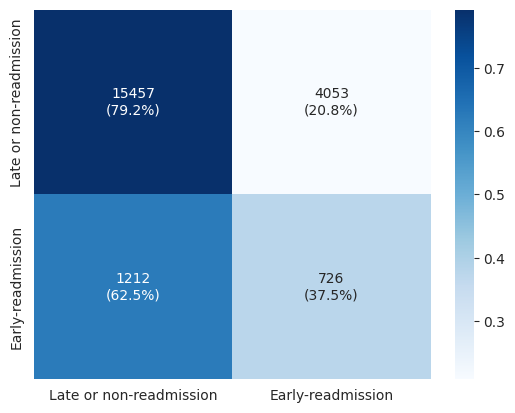

In [66]:
# Visualize confusion matrix with both absolute and percentage values
cm_smotetomek = confusion_matrix(y_test, y_test_pred_smotetomek)
cm_smotetomek_norm = confusion_matrix(y_test, y_test_pred_smotetomek, normalize='true')

annotations_smotetomek = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smotetomek, cm_smotetomek_norm)
])

sns.heatmap(
    cm_smotetomek_norm,
    annot=annotations_smotetomek,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **6. Results Combined**
Visualizing all results obtained by different sampling methods, on the best respective models.

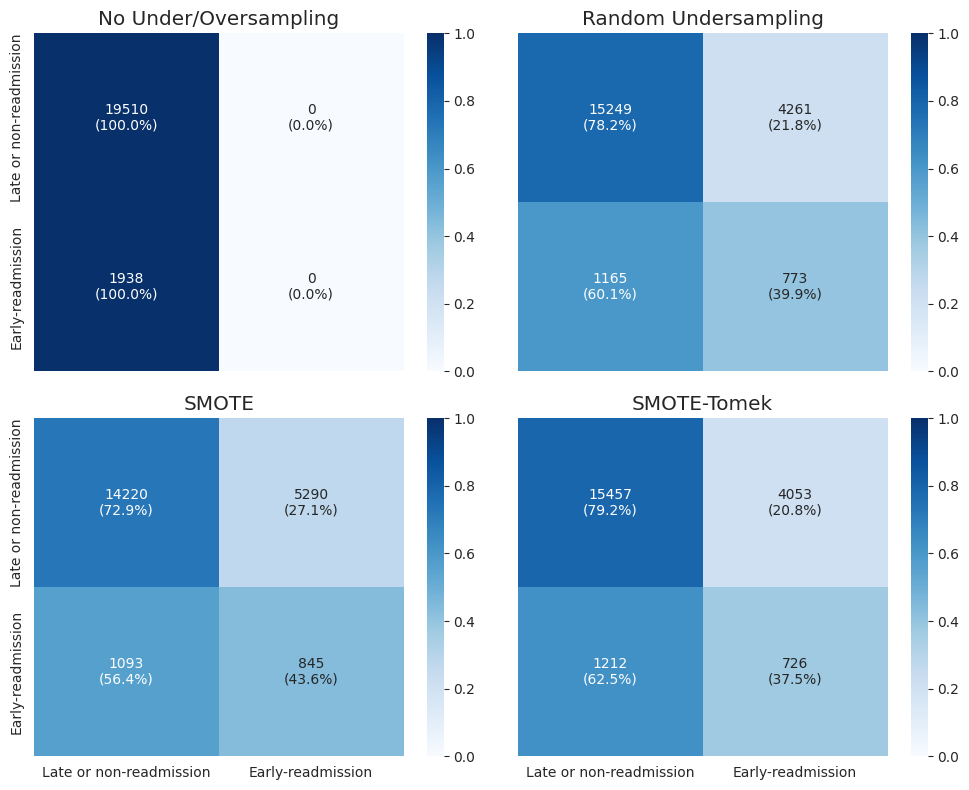

In [72]:
# Combine all confusion matrices into a single plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
cm_list = [cm_none_norm, cm_rus_norm, cm_smote_norm, cm_smotetomek_norm]
annotations = [annotations_none, annotations_rus, annotations_smote, annotations_smotetomek]
labels = ['No Under/Oversampling', 'Random Undersampling', 'SMOTE', 'SMOTE-Tomek']

# Define tick labels
xticklabels = ['Late or non-readmission', 'Early-readmission']
yticklabels = ['Late or non-readmission', 'Early-readmission']

for i, cm in enumerate(cm_list):
    ax=axs[i//2, i%2]
    sns.heatmap(
        cm,
        annot=annotations[i],
        cmap='Blues',
        fmt='',
        vmin=0, vmax=1,
        ax=axs[i//2, i%2],
        xticklabels=['Late or non-readmission', 'Early-readmission'],
        yticklabels=['Late or non-readmission', 'Early-readmission']
    )
    ax.set_title(labels[i])
    ax.xaxis.set_tick_params(rotation=0)
    ax.yaxis.set_tick_params(rotation=90)
    
    # Hide x-tick labels for the top row
    if i < 2:
        ax.set_xticklabels([])
    # Hide y-tick labels for the right column
    if i % 2 == 1:
        ax.set_yticklabels([])

plt.tight_layout()
plt.show()

Visualizing the scores for each method.

In [68]:
# Combine all metrics into a single DataFrame
data = {
    'Recall': [recall_none, recall_rus, recall_smote, recall_smotetomek],
    'Precision': [precision_none, precision_rus, precision_smote, precision_smotetomek],
    'F1-score': [f1_none, f1_rus, f1_smote, f1_smotetomek],
    'ROC-AUC': [roc_auc_none, roc_auc_rus, roc_auc_smote, roc_auc_smotetomek],
    'Accuracy': [accuracy_none, accuracy_rus, accuracy_smote, accuracy_smotetomek]
}

metrics_df = pd.DataFrame(data, index=labels)
metrics_df

Recall  Precision  F1-score   ROC-AUC  Accuracy
No Under/Oversampling  0.500000   0.454821  0.476342  0.500000  0.909642
Random Undersampling   0.590232   0.541290  0.535352  0.590232  0.747016
SMOTE                  0.582437   0.533179  0.513021  0.582437  0.702396
SMOTE-Tomek            0.583437   0.539602  0.535321  0.583437  0.754523

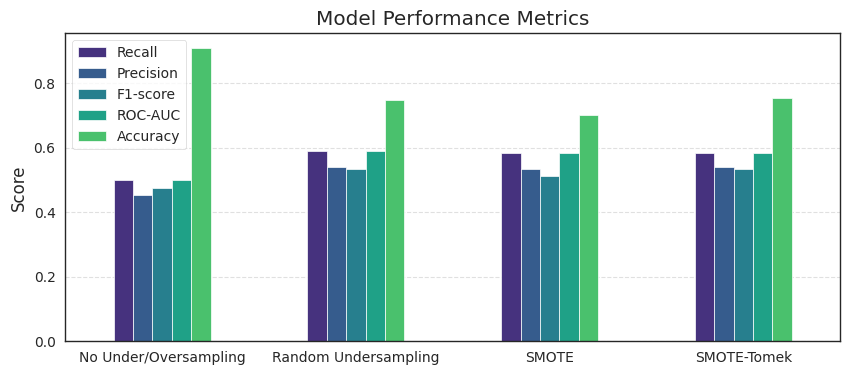

In [69]:
# Visualize all metrics in a bar plot, by coloring each method differently, using SeaBorn barplot and adding grids
sns.set_palette('viridis')
metrics_df.plot(kind='bar', figsize=(10, 4))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()